# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3 as sq
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from tqdm import tqdm_notebook as tqdm
import os
from prettytable import PrettyTable
from scipy.sparse import hstack,csr_matrix
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,train_test_split
import matplotlib.pyplot as plt
import seaborn as sn 
from sklearn.pipeline import FeatureUnion

ModuleNotFoundError: No module named 'gensim'

In [70]:
# using SQLite Table to read data.
con = sq.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [71]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [72]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [73]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [74]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [75]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [76]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [77]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [78]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [79]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [80]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [81]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [82]:
# printing some random reviews
print("Printing Some Random Review :")
print('#'*117)
sent_0 = final['Text'].values[0]
print(sent_0)
print("@"*117)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("@"*117)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("@"*117)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("#"*117)


Printing Some Random Review :
#####################################################################################################################
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego 

In [83]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_4900)

Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)


In [84]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*117)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*117)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*117)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [85]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [86]:
sent_1500 = decontracted(sent_0)
print(sent_1500)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we are driving along and he always can sing the refrain. he is learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [87]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_1000).strip()
print(sent_0)

I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered  boxes - both were expired! One expired back in  for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez,  years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.


In [88]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

this witty little book makes my son laugh at loud i recite it in the car as we are driving along and he always can sing the refrain he is learned about whales India drooping roses i love all the new words this book introduces and the silliness of it all this is a classic book i am willing to bet my son will STILL be able to recite from memory when he is in college


In [89]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [90]:
# Combining all the above pre - processing steps 
from tqdm import tqdm
preprocessed_reviews = []
snowBall = SnowballStemmer('english')
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values,position= 0,mininterval= 1):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(snowBall.stem(words) for words in sentence.split())
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [06:11<00:00, 980.36it/s]


In [91]:
preprocessed_reviews[2500]

'salt free season blend great product sanction salt consumpt great flavor much less expens via amazon com store purchas find'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [92]:
## Performing Preprocessing for Summary review.
preprocessed_summary = []
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
for summ_sentence in final['Summary'].values:
    summ_sentence = re.sub(r"http\S+","",summ_sentence)
    summ_sentence = BeautifulSoup(summ_sentence, 'lxml').get_text()
    summ_sentence = decontracted(summ_sentence)
    summ_sentence = re.sub("\S*\d\S*", "",summ_sentence)
    summ_sentence = re.sub('[^A-Za-z]+',' ',summ_sentence)
    summ_sentence = ' '.join(snowBall.stem(words) for words in summ_sentence.split())
    summ_sentence = ' '.join(e.lower() for e in summ_sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summ_sentence.strip())


In [93]:
preprocessed_summary[2500] # preprocessed summary review

'product quality'

In [94]:
#Storing the review text and summary with preprocessed values
final['Text'] = preprocessed_reviews
final['Summary'] = preprocessed_summary

In [95]:
#Storing the preprocessed dataframe on HDD
conn = sq.connect('AmazonReviewFiltered.sqlite')
final.to_sql('Reviews', conn,if_exists= 'replace' )

In [33]:
conn = sq.connect('AmazonReviewFiltered.sqlite')
AmazonReviewDataFiltered = pd.read_sql_query("""SELECT * FROM Reviews """, conn)

In [34]:
AmazonReviewDataFiltered.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,every book educational,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,love book miss hard cover version,grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup rice months,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,good swingy rhythm reading aloud,great littl book read aloud nice rhythm well g...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,great way learn months,book poetri month year goe month cute littl po...


In [38]:
AmazonReviewDataFiltered['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [39]:
# Sampling 100k data points from AmazonREviewDataFiltered to perform BoW, TF - IDF, word2vec and TF - IDF avgerage w2v, to reduce processing time.
AmazonPositiveReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 1].sample(n =84300) # Sampling 84300 positive data points from AmazonReviewDataFiltered, i.e. 84.3%
AmazonNegativeReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 0].sample(n = 15700) # Sampling 15700 negative data points from AmazonReviewDataFiltered, i.e. 15.7%
AmazonReviewDataSampled = AmazonPositiveReviewData.append(AmazonNegativeReviewData, ignore_index= True) # Appending the samples of positive and negative data points to form AmazonReviewDataSampled 
AmazonReviewDataSampled.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,519720,561895,B00021XV44,A2G66TBZM7DU8S,R.R.,0,0,1,1194393600,simply delicious,bought jar bonni countri classic mustard bbq s...
1,94164,102357,B000J0R11C,A32TZ4HWVHBYX7,cowgirl,2,3,1,1297641600,great green tea,green tea everi morn place coffe drink straigh...
2,353120,381952,B0012C643C,A12PR2WHNILMKZ,Dna,2,2,1,1240876800,good soy,good ani soy milk tast creami not sweet less s...
3,61404,66722,B004UGACUI,A3KRGRGL1AS3UW,M. July,2,2,1,1323043200,skeptical love,nice natur healthi drink boost energi mid day ...


In [40]:
AmazonReviewDataSampled.tail(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
99996,297200,321929,B000LKU4VE,A21XAQ9670N7EV,sage,1,4,0,1225843200,not even close,decid could word cheddar includ packag bear ab...
99997,24074,26326,B000121BY6,A3BOGELRQJK8OE,a gentle sound,2,13,0,1248739200,like something might find sale four year olds ...,first tast caf next moulin roug pari degre rem...
99998,250512,271623,B001E52ZJ4,A2AQG5XNTUDNLN,N. Ryan,6,14,0,1233273600,picture misleading,love oatmeal go bar hard time find store late ...
99999,43564,47400,B001EQ4DIY,AMYHSFH1R363L,Hippie Mom,2,8,0,1329696000,not gluten free,member famili celiac diseas fruiti pebbl start...


In [41]:
AmazonReviewDataSampled['Score'].value_counts()

1    84300
0    15700
Name: Score, dtype: int64

In [2]:
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled.to_sql('Reviews', conn,if_exists= 'replace' )

NameError: name 'AmazonReviewDataSampled' is not defined

In [2]:
con = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [3]:
AmazonReviewDataSampled['Score'].value_counts()

1    84300
0    15700
Name: Score, dtype: int64

In [4]:
# Program to split and sort the positive and negative reviews of the amazon dataset based on time.
AmazonReviewDataSampledPositive = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 1]

AmazonReviewDataSampledNegative = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 0]
# Program to sort the positive and negative review dataset with respect to time.
AmazonReviewDataSampledPositive.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True )
AmazonReviewDataSampledNegative.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True)

In [5]:
AmazonReviewDataSampledPositive.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1332,1332,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole series great way spend time child,rememb see show air televis year ago child sis...
16092,16092,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,modern day fairy tale,twist rumplestiskin captur film star michael k...
8202,8202,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,bettlejuice bettlejuice bettlejuice,happen say name three time michael keaten star...
8509,8509,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,wow make islickers,receiv shipment could hard wait tri product lo...


In [6]:
AmazonReviewDataSampledNegative.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
88636,88636,346037,374339,B00004CI84,AZRJH4JFB59VC,Lynwood E. Hines,21,23,0,997228800,great movie terrible dvd,continu amaz shoddi treatment movi get dvd rel...
92097,92097,346040,374342,B00004CI84,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,0,1040947200,great movie turned bad,let know movi one person favorit ghost movi sa...
94286,94286,428912,463849,B0000SXEKA,A2801SG8XA9LNX,PACW,7,8,0,1069113600,ohhh ick,frost sweet low calori whenev come across term...
95391,95391,264269,286453,B0000DJ7WI,A375QRG43POEW6,dndnd,23,25,0,1069977600,stay away,product ship great packag look good tast horri...


In [7]:
# Performing Time Based Spliting of the positive and negative reviews to form 70% of train and 30% of test dataset.
Positive_tr = AmazonReviewDataSampledPositive[0:59010]

Positive_ts = AmazonReviewDataSampledPositive[59010:]

Negative_tr = AmazonReviewDataSampledNegative[0:10990]
Negative_ts = AmazonReviewDataSampledNegative[10990:]

AmazonReviewDataSampledTrain = Positive_tr.append(Negative_tr, ignore_index = True)
AmazonReviewDataSampledTest = Positive_ts.append(Negative_ts, ignore_index = True)

In [8]:
AmazonReviewDataSampledTrain.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1332,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole series great way spend time child,rememb see show air televis year ago child sis...
1,16092,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,modern day fairy tale,twist rumplestiskin captur film star michael k...
2,8202,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,bettlejuice bettlejuice bettlejuice,happen say name three time michael keaten star...
3,8509,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,wow make islickers,receiv shipment could hard wait tri product lo...


In [9]:
AmazonReviewDataSampledTest.head(4)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,65454,352858,381683,B002RBOD3A,A2O5UQITL4TWON,christine hamrick,0,0,1,1328400000,omg choclate,first purchas lindt websit becaus could not fi...
1,24159,192336,208553,B002GWMATY,A2TS9N60M404XL,Connie Simpson,1,1,1,1328486400,great deal,read review hope product veri pleas tea order ...
2,64919,393836,425887,B000TQEWM2,A2E8DBCB729PNS,"Charles E. Stegman ""football fan""",0,0,1,1328486400,great coffee wife favorite,wife favorit coffe
3,739,238341,258573,B000NVAJI4,A2SSRYECENACTO,Lisa B.,0,0,1,1328486400,love herbs,aromat aesthet appeal herb great type offood m...


In [10]:
AmazonReviewDataSampledTrain['Score'].value_counts()

1    59010
0    10990
Name: Score, dtype: int64

In [11]:
AmazonReviewDataSampledTest['Score'].value_counts()

1    25290
0     4710
Name: Score, dtype: int64

In [25]:
AmazonReviewDataSampledTrain_RBF = AmazonReviewDataSampledTrain.sample(40000,random_state= 6)
AmazonReviewDataSampledTrain_RBF.shape

(40000, 12)

# [4] Featurization

## [4.1] BAG OF WORDS

In [12]:
#BoW
#Performing Bag of words vectorizer using sklearn inbuit function countvectorizer for train and test data for review text
bagofwords = CountVectorizer() #in scikit-learn
bagofwords.fit(AmazonReviewDataSampledTrain['Text'])
print("some feature names ", bagofwords.get_feature_names()[:10])
print('='*117)


bowTrain = bagofwords.transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(bowTrain))
print("the shape of our text BOW Train vectorizer ",bowTrain.get_shape())
print("the number of unique words ", bowTrain.get_shape()[1])
print("*"*117)

bowTest = bagofwords.transform(AmazonReviewDataSampledTest['Text'])
print("The shape of our text BOW Test vectorizer:" , bowTest.get_shape())


some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaaaaagghh', 'aaaaaahhh', 'aaaaaahhhh', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaand', 'aaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW Train vectorizer  (70000, 35487)
the number of unique words  35487
*********************************************************************************************************************
The shape of our text BOW Test vectorizer: (30000, 35487)


In [13]:
#Standardizing the bag of word vectorizer using Max Absolute scaler since bag of words vectorizer is a CSR matrix
maxscaler = MaxAbsScaler()
bowTrain = maxscaler.fit_transform(bowTrain)
bowTest = maxscaler.transform(bowTest)

In [14]:
#BoW
#Performing bag of words vectorizer using countvectorizer for train and test data for summary review
bagofwordsSum = CountVectorizer() #in scikit-learn
bagofwordsSum.fit(AmazonReviewDataSampledTrain['Summary'])
print("some feature names ", bagofwordsSum.get_feature_names()[:10])
print('='*117)

bowTrainSum = bagofwordsSum.transform(AmazonReviewDataSampledTrain['Summary'])
print("the type of count vectorizer ",type(bowTrainSum))
print("the shape of our text BOW Train vectorizer ",bowTrainSum.get_shape())
print("the number of unique words ", bowTrainSum.get_shape()[1])
print("*"*117)

bowTestSum = bagofwordsSum.transform(AmazonReviewDataSampledTest['Summary'])
print("The shape of our text BOW Test vectorizer:" , bowTestSum.get_shape())


some feature names  ['aa', 'aaa', 'aaaaaagh', 'aaaammmmaaaaazziiiinnnnggg', 'aaaarrrrrgggghhhhh', 'aaah', 'aack', 'aardvark', 'abbey', 'abc']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW Train vectorizer  (70000, 13743)
the number of unique words  13743
*********************************************************************************************************************
The shape of our text BOW Test vectorizer: (30000, 13743)


In [15]:
#Column standardization
maxscaler = MaxAbsScaler()
bowTrainSum = maxscaler.fit_transform(bowTrainSum)
bowTestSum = maxscaler.transform(bowTestSum)

## [4.2] Bi-Grams and n-Grams.

In [18]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numbers min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [19]:
#Performing TFIDF vectorizer for train and test data using text review
tfidfVec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidfVec.fit(AmazonReviewDataSampledTrain['Text'])
print("some sample features(unique words in the corpus)",tfidfVec.get_feature_names()[0:10])
print('='*117)

tfidfTrain = tfidfVec.transform(AmazonReviewDataSampledTrain['Text'])
print("the type of count vectorizer ",type(tfidfTrain))
print("the shape of out text TFIDF Train vectorizer ",tfidfTrain.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidfTrain.get_shape()[1])
print('*'*117)
tfidfTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])
print("the shape of out text TFIDF Test vectorizer ",tfidfTest.get_shape())
print('='*117)

some sample features(unique words in the corpus) ['aa', 'aback', 'abandon', 'abil', 'abl', 'abl add', 'abl buy', 'abl chew', 'abl continu', 'abl drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF Train vectorizer  (70000, 43544)
the number of unique words including both unigrams and bigrams  43544
*********************************************************************************************************************
the shape of out text TFIDF Test vectorizer  (30000, 43544)


In [20]:
#Column standardization
maxscaler = MaxAbsScaler()
tfidfTrain = maxscaler.fit_transform(tfidfTrain)
tfidfTest = maxscaler.transform(tfidfTest)

In [21]:
#TFIDF vectorizer for train and test data for summary review
tfidfVecSum = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidfVecSum.fit(AmazonReviewDataSampledTrain['Summary'])
print("some sample features(unique words in the corpus)",tfidfVecSum.get_feature_names()[0:10])
print('='*117)

tfidfTrainSum = tfidfVecSum.transform(AmazonReviewDataSampledTrain['Summary'])
print("the type of count vectorizer ",type(tfidfTrainSum))
print("the shape of out text TFIDF Train vectorizer ",tfidfTrainSum.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidfTrainSum.get_shape()[1])
print('*'*117)
tfidfTestSum = tfidfVecSum.transform(AmazonReviewDataSampledTest['Summary'])
print("the shape of out text TFIDF Test vectorizer ",tfidfTestSum.get_shape())
print('='*117)

some sample features(unique words in the corpus) ['able', 'absolute', 'absolute best', 'absolutely', 'absolutely best', 'absolutely delicious', 'absolutely love', 'absolutely wonderful', 'acai', 'acid']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF Train vectorizer  (70000, 3451)
the number of unique words including both unigrams and bigrams  3451
*********************************************************************************************************************
the shape of out text TFIDF Test vectorizer  (30000, 3451)


In [22]:
#Column standardization
maxscaler = MaxAbsScaler()
tfidfTrainSum = maxscaler.fit_transform(tfidfTrainSum)
tfidfTestSum = maxscaler.transform(tfidfTestSum)

## [4.4] Word2Vec

In [23]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in AmazonReviewDataSampledTrain['Text']:
    list_of_sentance.append(sentance.split())

In [24]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*117)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantast', 0.8035915493965149), ('wonder', 0.800906777381897), ('terrif', 0.7901496887207031), ('excel', 0.7818833589553833), ('good', 0.7694945335388184), ('awesom', 0.752051830291748), ('perfect', 0.7150365710258484), ('nice', 0.7005941271781921), ('decent', 0.6884441375732422), ('fabul', 0.673021137714386)]
[('best', 0.8238265514373779), ('tastiest', 0.7150055170059204), ('greatest', 0.7004100680351257), ('lightest', 0.662519097328186), ('healthiest', 0.63987135887146), ('closest', 0.6266630291938782), ('freshest', 0.6006902456283569), ('nastiest', 0.5916823148727417), ('coolest', 0.5816793441772461), ('weakest', 0.5609681010246277)]


In [25]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11137
sample words  ['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'book', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'cd', 'along', 'children', 'tradit', 'live', 'twist', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'not', 'dull', 'moment']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v for Text review

In [26]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTrain = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTrain['Text'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTrain.append(sent_vec)
#print(len(avgW2VTrain))
print('The shape of avgerage word to vector for Train data  is ','(',len(avgW2VTrain),',',len(avgW2VTrain[0]),')')
#column standzrdization
scale = StandardScaler()
avgW2VTrain = scale.fit_transform(avgW2VTrain)


The shape of avgerage word to vector for Train data  is  ( 70000 , 50 )


In [27]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTest['Text'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTest.append(sent_vec)
print('The shape of avgerage word to vector for Test data  is ','(',len(avgW2VTest),',',len(avgW2VTest[0]),')')
avgW2VTest = scale.transform(avgW2VTest)# column standardization


The shape of avgerage word to vector for Test data  is  ( 30000 , 50 )


<b> AVG W2V for Summary

In [28]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTrainSum = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTrain['Summary'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTrainSum.append(sent_vec)
#print(len(avgW2VTrain))
print('The shape of avgerage word to vector for Train data  is ','(',len(avgW2VTrainSum),',',len(avgW2VTrainSum[0]),')')
#column standardization
scale = StandardScaler()
avgW2VTrainSum = scale.fit_transform(avgW2VTrainSum)


The shape of avgerage word to vector for Train data  is  ( 70000 , 50 )


In [29]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTestSum = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTest['Summary'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTestSum.append(sent_vec)
print('The shape of avgerage word to vector for Test data  is ','(',len(avgW2VTestSum),',',len(avgW2VTestSum[0]),')')
avgW2VTestSum = scale.transform(avgW2VTestSum)# column standardization


The shape of avgerage word to vector for Test data  is  ( 30000 , 50 )


#### [4.4.1.2] TFIDF weighted W2v for text review


In [30]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(AmazonReviewDataSampledTrain['Text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [31]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2vTrain = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTrain['Text'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTrain.append(sent_vec)
    row += 1



In [32]:

tfidfw2vTest = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTest['Text'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTest.append(sent_vec)
    row += 1

In [33]:
#column standardization
scale = StandardScaler()
tfidfw2vTrain = scale.fit_transform(tfidfw2vTrain)
tfidfw2vTest = scale.transform(tfidfw2vTest)

### TFIDFAVGW2V for summary review

In [34]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrixSum = model.fit_transform(AmazonReviewDataSampledTrain['Summary'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2vTrainSum = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTrain['Summary'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTrainSum.append(sent_vec)
    row += 1



In [35]:

tfidfw2vTestSum = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTest['Summary'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTestSum.append(sent_vec)
    row += 1

In [36]:
#Column standardization
scale = StandardScaler()
tfidfw2vTrainSum = scale.fit_transform(tfidfw2vTrainSum)
tfidfw2vTestSum = scale.transform(tfidfw2vTestSum)

# Applying SVM

## [5.1] Linear SVM

In [37]:
def clf(x_train,y_train,kernel,regularizer = 'l2',n_splits = 10):
    """Function to determine the optimal value of hyperparameter alpha for Linear and RBF kernel SVM
    Parameters:
    x_train : array-like or sparse matrix of shape = [n_samples, n_features], the training input samples
    y_train : actual output
    Kernel : Linear or RBF
    regularizer : The penalty term, either L2 or L1. Default = L2
    n_splits : Number of splits for cross validation. Default = 10. only for Linear SVM.
    
    returns the optimal hyperparameter for the RBF or linear SVM.
    
    """
    cv_scores = [] # list to store the cv scores
    trainscores = []# list to store the train scores
    cv = KFold(n_splits= n_splits,shuffle=True) # cv folds
    
    if kernel == 'rbf':
        x_train , x_cv, y_train , y_cv = train_test_split(x_train,y_train,test_size = 0.20)
        tuned_parameters = [10**(-4),10**-3, 10**-2,10**-1, 10**0,10**1, 10**2, 10**3,10**(4)]
        for x in tuned_parameters:
            classifier = SVC(C= x,kernel='rbf',class_weight= 'balanced') # kernel SVM with balanced class weight
            classifier.fit(x_train,y_train)
            pred = classifier.predict(x_cv)# predicting output using cv data
            predT = classifier.predict(x_train) # predicting output using train data
            scores = roc_auc_score(y_cv,pred)# auc for cv
            scoresT = roc_auc_score(y_train,predT)# auc for train data
            trainscores.append(scoresT)
            cv_scores.append(scores)
            print('For alpha = %r , auc for train data = %r and auc for cv = %r '%(x,scoresT,scores))
            #table3.add_row([x,scoresT,scores])
        
    else:
        tuned_parameters = [10**(-4),10**-3, 10**-2,10**-1, 10**0,10**1, 10**2, 10**3,10**(4)]
        for x in tuned_parameters:
            scores = 0.0
            scoresT = 0.0
            classifier = SGDClassifier(loss='hinge',penalty= regularizer,l1_ratio= 0,class_weight='balanced',alpha = x)# linear SVM using SGD with hinge loss
            calibclassifier = CalibratedClassifierCV(base_estimator= classifier,cv = 10, method='sigmoid')# calibrating the linear SVM classifier.
            for train, test in cv.split(x_train, y_train):
                calibclassifier.fit(x_train[train],y_train[train])
                pred = calibclassifier.predict(x_train[test]) # prediction using CV 
                predT = calibclassifier.predict(x_train[train])# prediction using Train data
                scores += roc_auc_score(y_train[test],pred) # AUC for CV
                scoresT += roc_auc_score(y_train[train],predT)# AUC for Train data
            scoresT /= n_splits # mean auc for cv
            scores /= n_splits# mean auc for train
            trainscores.append(scoresT)
            cv_scores.append(scores)
            print('For alpha = %r , auc for train data = %r and auc for cv = %r '%(x,scoresT,scores))
            
    #To plot auc of CV and Train data for different values of hyperparameter.                   
    plt.figure(figsize=(20,10))
    plt.plot(tuned_parameters,cv_scores,label = 'CV score')
    plt.plot(tuned_parameters,trainscores,label = 'train score')
    plt.xlim(10**(-4),10**4)
    plt.xscale('log')
    plt.legend()
    plt.title("Plot of AUC for Train and CV")
    plt.xlabel('Hyper-parameter')
    plt.ylabel('AUC')
    plt.show()
    return tuned_parameters[np.argmax(cv_scores)]
    
    
                             
def clfperformance(x_train,y_train,x_test,y_test,optimal_alpha,penalty = 'l2',svc = 'linear'):
    """Function to predict the output using linear or RBF kernel SVM.
    Parameters:
    x_train  : array-like or sparse matrix of shape = [n_samples, n_features], the training input samples
    y_train : actual output of x_train
    x_test : array-like or sparse matrix of shape = [n_samples, n_features]. the test data.
    y_test : actual output of x_test
    optimal_alpha = hyperparameter alpha of RBF /linear SVM
    penalty : L2 / L1 for linear SVM. default = L2
    svc = linear / kernel svm . default = linear
    
    """
    coef = 0.0
    if svc == 'linear':
        model = SGDClassifier(loss='hinge',penalty= penalty,l1_ratio= 0,class_weight='balanced',alpha = optimal_alpha) # linear SVM using SGD with hinge loss
        model.fit(x_train,y_train)
        model_cal = CalibratedClassifierCV(base_estimator= model,cv = 10, method='sigmoid')# calibrating the SGD model
        coef = model.coef_
    else:
        model_cal = SVC(C= optimal_alpha,kernel='rbf',class_weight= 'balanced')
        
    model_cal.fit(x_train,y_train)
    predict = model_cal.predict(x_test) # predict the output
    auc_test = roc_auc_score(y_test,predict) # auc for test data
    auc_train = roc_auc_score(y_train,model_cal.predict(x_train))# auc for train data
    print('AUC for Train data is  ',auc_train,'\n')
    print('AUC for the Test data is  ', auc_test,'\n')
    confusionMatrix = confusion_matrix(y_test,predict) # confusion matrix
    TPR = (confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])) * 100 # calculating the TPR 
    TNR = (confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])) * 100 # calculating the TNR
    fprTest,tprTest,thresholdTest = roc_curve(y_test,predict) # roc curve for test data
    fprTrain,tprTrain,thresholdTrain = roc_curve(y_train,model_cal.predict(x_train))# roc curve for train data
    # Plot of roc curve for test and train data
    plt.figure(figsize=(20,10))
    plt.plot(fprTest,tprTest,label = 'roc of Test data')
    plt.plot(fprTrain,tprTrain,label = 'roc of Train data')
    plt.legend()
    plt.title('Plot of ROC curve for Test and Train data')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    # plot of confusion matrix using heat map
    plt.figure(figsize=(20,10))
    sn.heatmap(confusionMatrix,annot=True,fmt="d")
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Heatmap of Confusion matrix')
    print('True positive rate =',TPR)
    print('True negative rate =',TNR)
    
    
    return auc_test,auc_train,TPR,TNR,coef 
    
def TopFeatures(numoffeat, vectorizer, coef):
    """Function to print top features in positive and negative class"""
    feature_names = vectorizer.get_feature_names()# obtaining the feature names for a particular vectorizer.
    coefs_with_fns = sorted(zip(coef, feature_names))# assigning each weights with its corresponding feature names
    top = zip(coefs_with_fns[:numoffeat], coefs_with_fns[:-(numoffeat + 1):-1])
    print("%r Most important features in Positive and Negative Class" % (numoffeat))
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("---------------------------------------------------------------------------------------------")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))  

In [38]:
# Pretty table to display Linear SVMm results
table2 = PrettyTable()
table2.field_names = ['Vectorizer', 'Type of SVM','Penalty','optimal Hyperparameter','AUC','TPR','TNR']

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

<b> Linear SVM with L2 penalty

For alpha = 0.0001 , auc for train data = 0.8767431920022467 and auc for cv = 0.7809380607499972 
For alpha = 0.001 , auc for train data = 0.8023111415739909 and auc for cv = 0.7645113591701176 
For alpha = 0.01 , auc for train data = 0.7150401695857687 and auc for cv = 0.7038456680062416 
For alpha = 0.1 , auc for train data = 0.7015361471950456 and auc for cv = 0.6931540263761145 
For alpha = 1 , auc for train data = 0.700978025665354 and auc for cv = 0.6928623142484873 
For alpha = 10 , auc for train data = 0.7006643046629775 and auc for cv = 0.6929714514956025 
For alpha = 100 , auc for train data = 0.7007349982211564 and auc for cv = 0.6921793008858119 
For alpha = 1000 , auc for train data = 0.7005871445204939 and auc for cv = 0.692742848817834 
For alpha = 10000 , auc for train data = 0.7009267570958919 and auc for cv = 0.692530250767769 


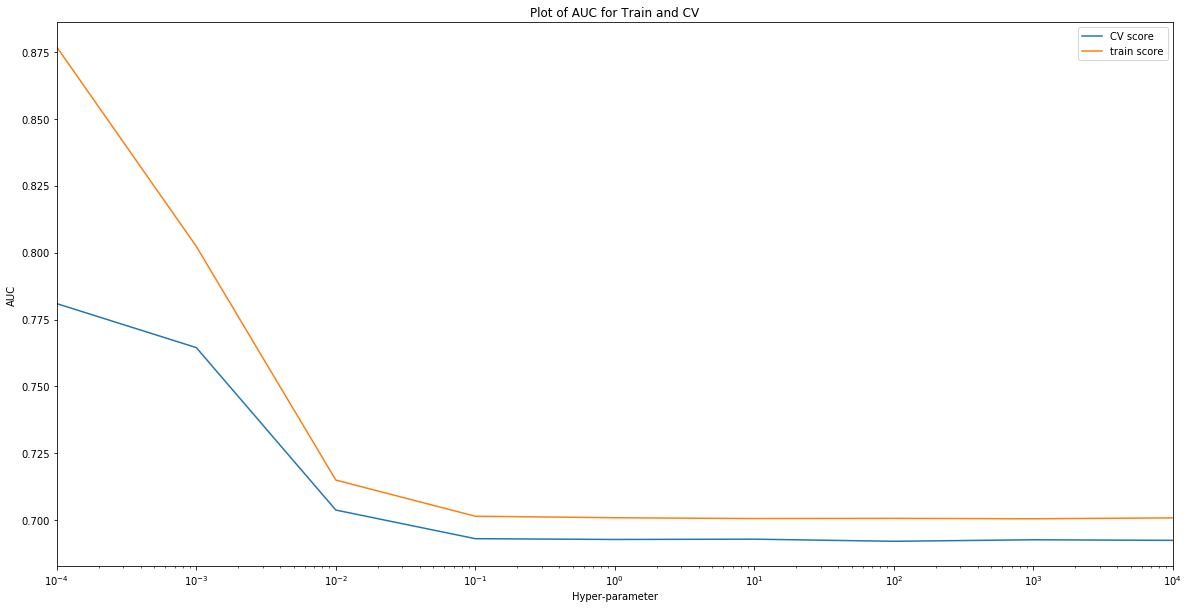

The optimal hyperparamter is  0.0001
*********************************************************************************************************************
AUC for Train data is   0.8675202950595657 

AUC for the Test data is   0.7848535334073788 



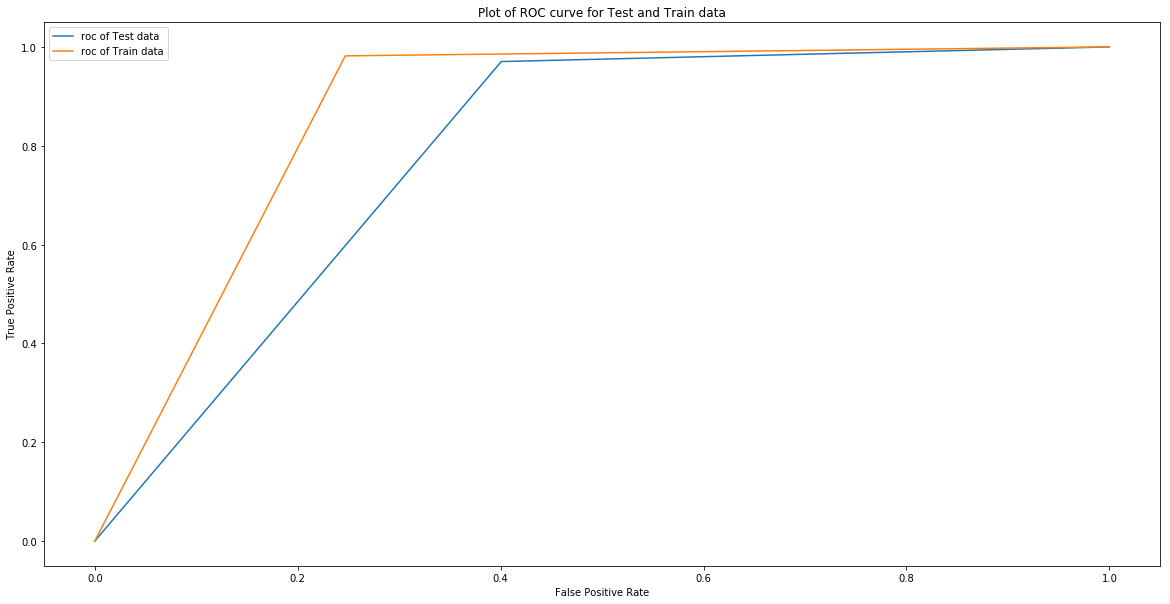

True positive rate = 97.03440094899169
True negative rate = 59.93630573248407
*********************************************************************************************************************
10 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-8.9787	not            				10.0207	great          
	-3.9672	disappoint     				6.0969	best           
	-3.5375	horribl        				5.4258	delici         
	-3.3903	worst          				3.8129	excel          
	-3.0040	tast           				3.4245	perfect        
	-2.9915	return         				3.1543	happi          
	-2.9772	bland          				3.1136	nice           
	-2.9535	aw             				3.0769	easi           
	-2.8218	would          				2.9858	awesom         
	-2.6888	stale          				2.7588	love           


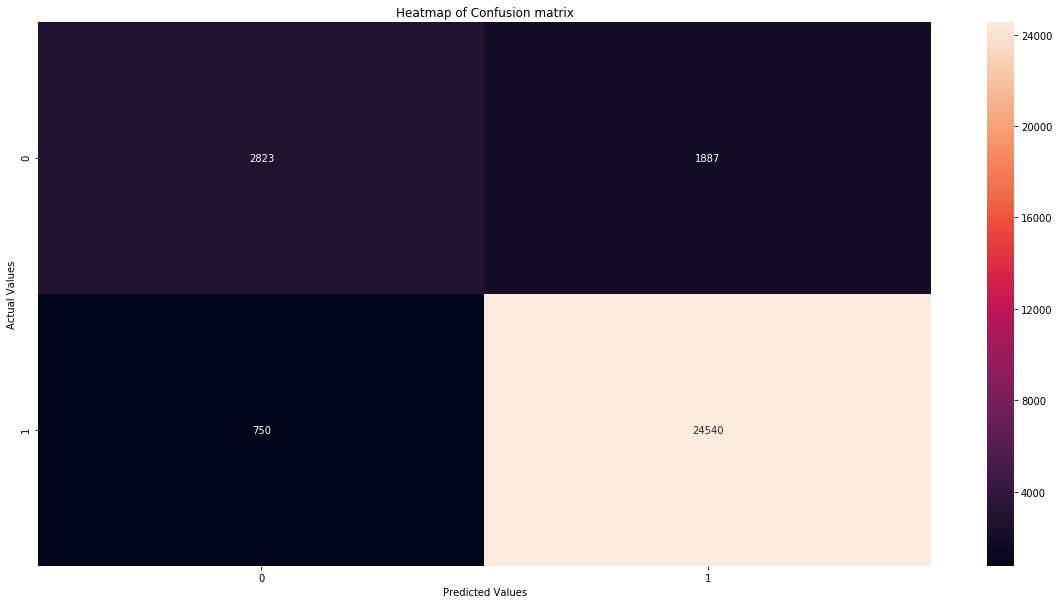

In [39]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(bowTrain, AmazonReviewDataSampledTrain['Score'],'linear','l2',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l2','linear')
table2.add_row(['Bag of Words','Linear','L2',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('*'*117)
TopFeatures(10,bagofwords,coef[0])
print('='*117)

<b> Linear SVM with L1 penalty

For alpha = 0.0001 , auc for train data = 0.7145577417757807 and auc for cv = 0.702995906667533 
For alpha = 0.001 , auc for train data = 0.6739890542620979 and auc for cv = 0.6712645474132165 
For alpha = 0.01 , auc for train data = 0.5440860746581986 and auc for cv = 0.5437130303673429 
For alpha = 0.1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 100 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1000 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10000 , auc for train data = 0.5 and auc for cv = 0.5 


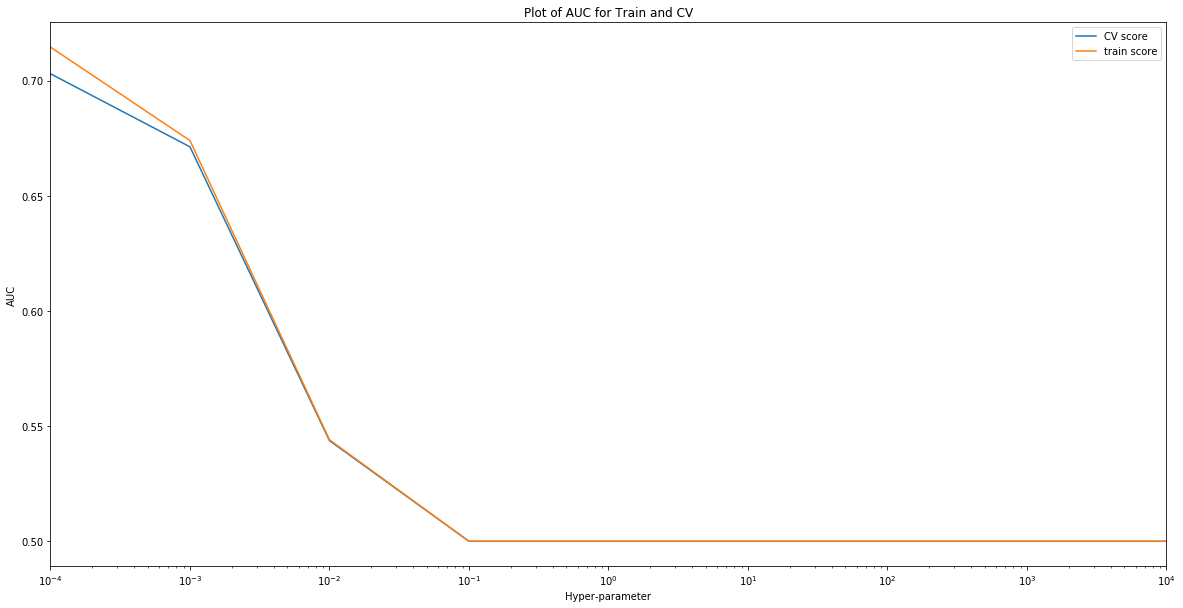

The optimal hyperparamter is  0.0001
*********************************************************************************************************************
AUC for Train data is   0.7206610776323132 

AUC for the Test data is   0.7099166861854715 



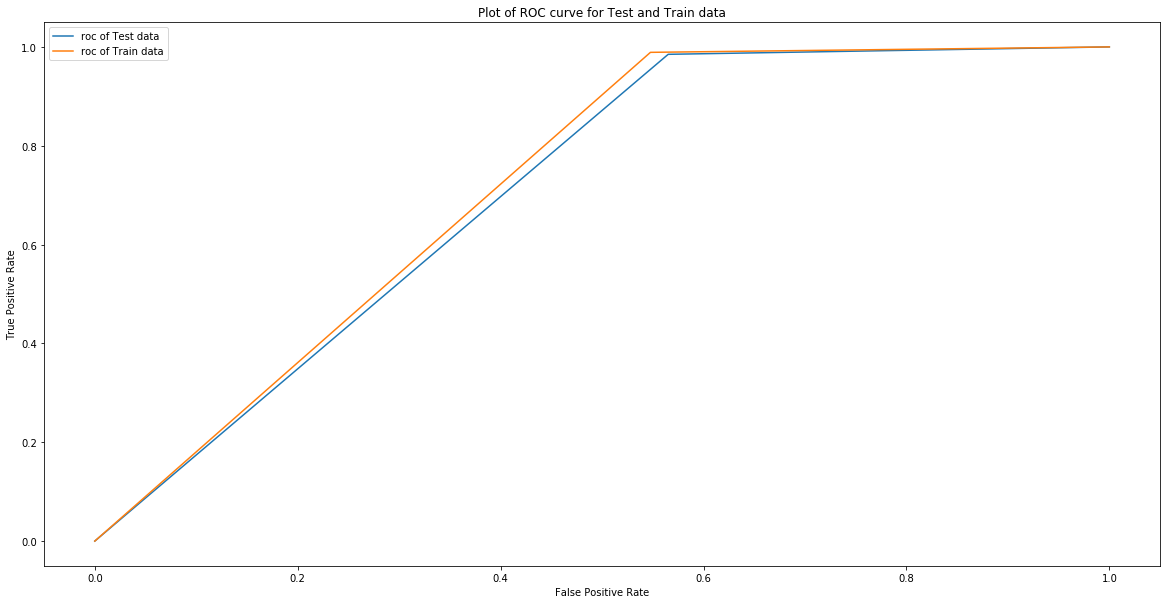

True positive rate = 98.50138394622381
True negative rate = 43.48195329087049
*********************************************************************************************************************
10 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-41.5175	weark          				37.1280	great          
	-40.6745	kavalacton     				22.3825	best           
	-38.7814	arrrrh         				20.5910	delici         
	-38.5217	brainwav       				13.5881	excel          
	-35.5486	healer         				12.1902	hook           
	-35.2722	waaaaaay       				10.6550	happi          
	-33.1291	siena          				10.5294	perfect        
	-32.5673	miscarriag     				10.2903	help           
	-30.8236	closet         				10.2614	awesom         
	-29.2499	excell         				10.0297	smooth         


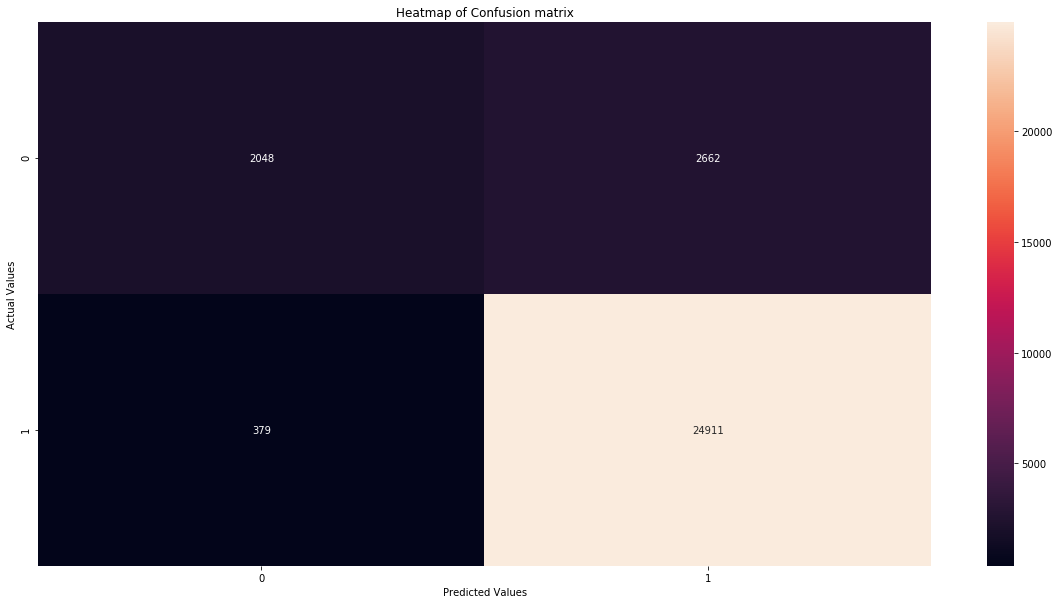

In [40]:
print('='*117)
optimal_alpha = clf(bowTrain, AmazonReviewDataSampledTrain['Score'],'linear','l1',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l1','linear')
table2.add_row(['Bag of Words','Linear','L1',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('*'*117)
TopFeatures(10,bagofwords,coef[0])
print('='*117)

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

<b> Linear SVM with L2 penalty

For alpha = 0.0001 , auc for train data = 0.9930218280997745 and auc for cv = 0.8326954535745028 
For alpha = 0.001 , auc for train data = 0.9193747452329806 and auc for cv = 0.8370421811174824 
For alpha = 0.01 , auc for train data = 0.7925388368508532 and auc for cv = 0.771313779623266 
For alpha = 0.1 , auc for train data = 0.7119666175081522 and auc for cv = 0.7039538181453346 
For alpha = 1 , auc for train data = 0.7121082423793866 and auc for cv = 0.7033737254511371 
For alpha = 10 , auc for train data = 0.7120372439152639 and auc for cv = 0.7029626132117457 
For alpha = 100 , auc for train data = 0.7121006591227947 and auc for cv = 0.7041698812817495 
For alpha = 1000 , auc for train data = 0.7123188216480882 and auc for cv = 0.7038723542946732 
For alpha = 10000 , auc for train data = 0.7120698485672972 and auc for cv = 0.7043006757669742 


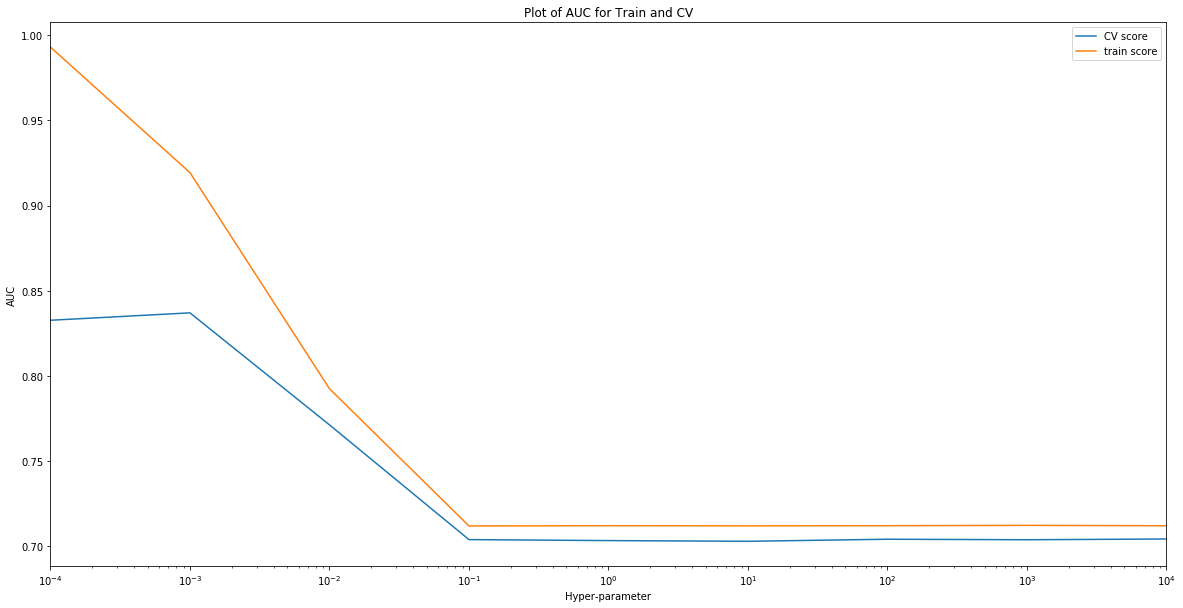

The optimal hyperparamter is  0.001
*********************************************************************************************************************
AUC for Train data is   0.9075045037168482 

AUC for the Test data is   0.846125076501122 



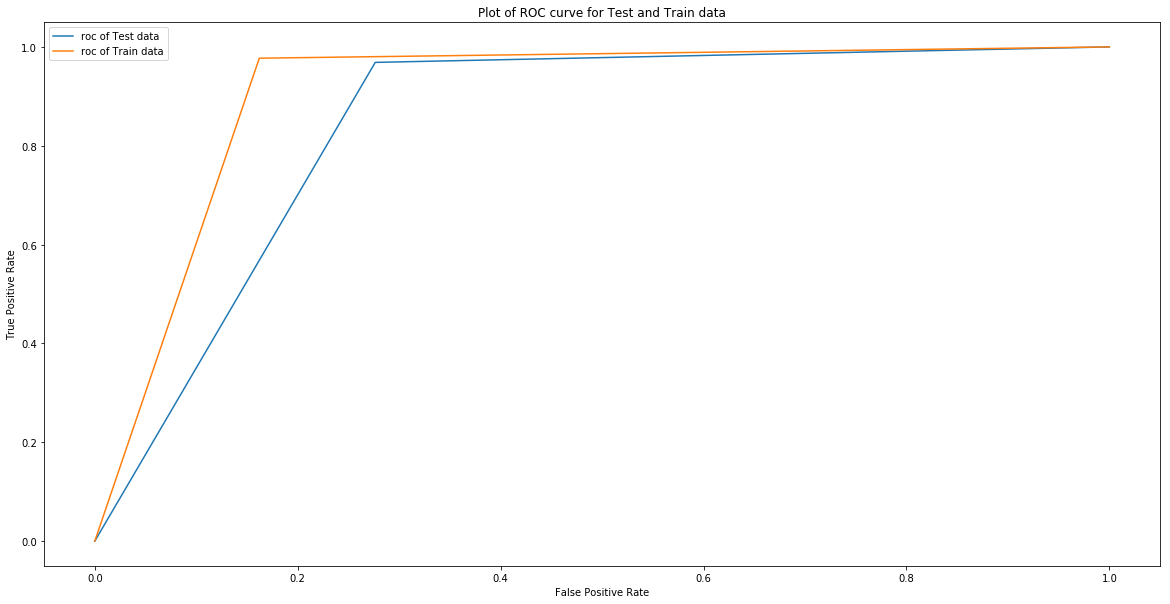

True positive rate = 96.86832740213524
True negative rate = 72.35668789808916
*********************************************************************************************************************
10 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-1.9101	disappoint     				2.3370	great          
	-1.5117	worst          				2.1411	love           
	-1.5042	not            				2.0228	best           
	-1.4100	not good       				1.8369	delici         
	-1.4088	not worth      				1.5121	perfect        
	-1.3093	not buy        				1.4722	good           
	-1.3054	aw             				1.3902	excel          
	-1.2715	unfortun       				1.3308	not disappoint 
	-1.1991	terribl        				1.1712	nice           
	-1.1489	bad            				1.1254	amaz           


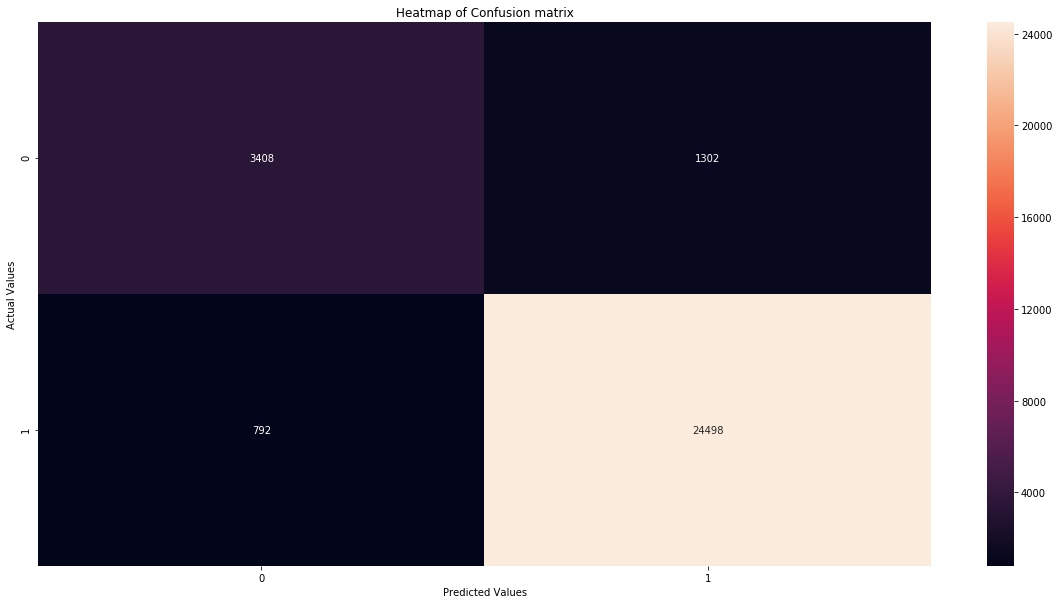

In [41]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(tfidfTrain, AmazonReviewDataSampledTrain['Score'],'linear','l2',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrain,AmazonReviewDataSampledTrain['Score'],tfidfTest,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l2','linear')
table2.add_row(['TFIDF','Linear','L2',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('*'*117)
TopFeatures(10,tfidfVec,coef[0])
print('='*117)

<b> Linear SVM with L1 penalty

For alpha = 0.0001 , auc for train data = 0.8011292404303132 and auc for cv = 0.7818423939578081 
For alpha = 0.001 , auc for train data = 0.6976548799768733 and auc for cv = 0.69353072987468 
For alpha = 0.01 , auc for train data = 0.5437612428159713 and auc for cv = 0.5432847358696915 
For alpha = 0.1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 100 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1000 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10000 , auc for train data = 0.5 and auc for cv = 0.5 


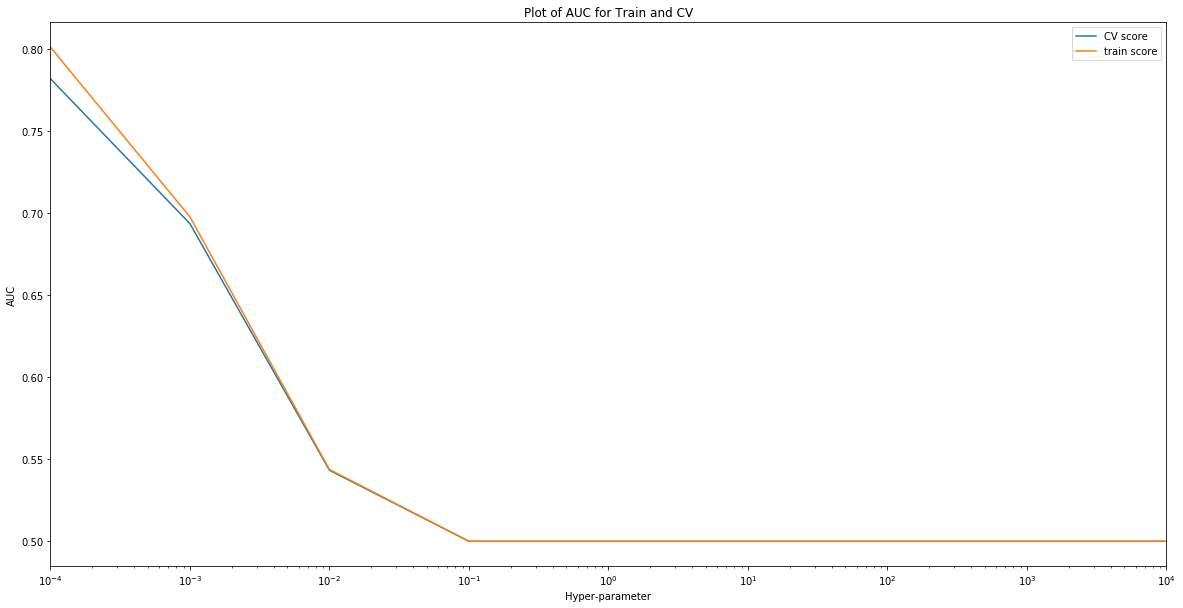

The optimal hyperparamter is  0.0001
*********************************************************************************************************************
AUC for Train data is   0.7980352568980535 

AUC for the Test data is   0.7912038191374955 



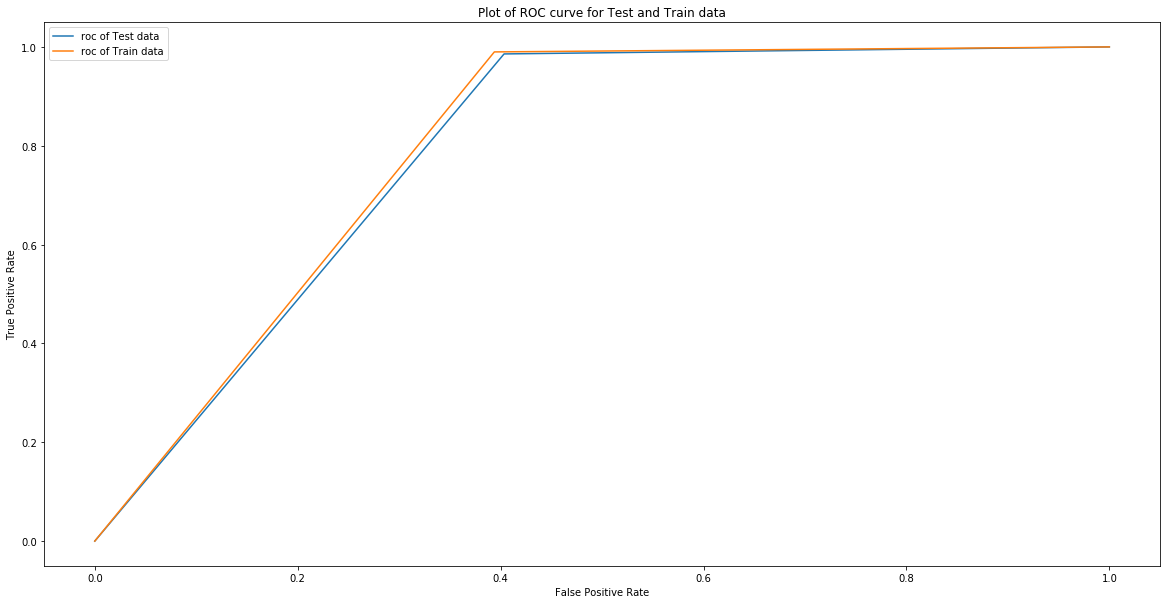

True positive rate = 98.58046658758403
True negative rate = 59.660297239915074
*********************************************************************************************************************
10 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-42.3953	sugar mean     				40.7938	love           
	-41.2549	not piec       				38.4336	delici         
	-37.5374	live florida   				28.0356	best           
	-36.5652	order chocol   				25.6963	not disappoint 
	-36.3412	nor ani        				24.4081	great          
	-36.0944	take treat     				24.3073	perfect        
	-34.9453	wont buy       				24.2374	high recommend 
	-34.7732	past day       				23.1019	excel          
	-34.7516	great dane     				18.3290	happi          
	-34.6426	first night    				18.3067	easi           


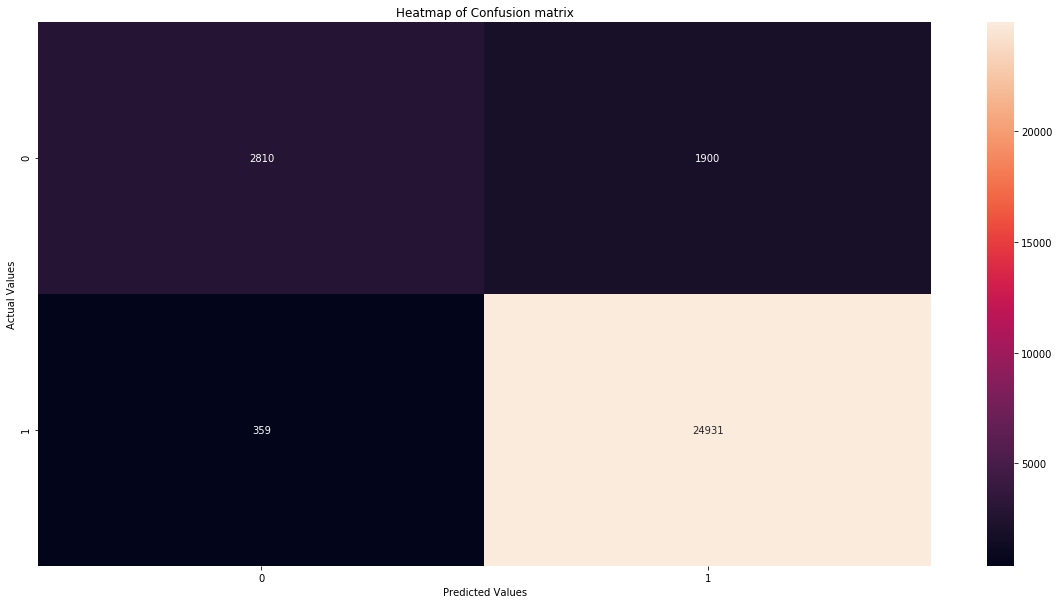

In [42]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(tfidfTrain, AmazonReviewDataSampledTrain['Score'],'linear','l1',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrain,AmazonReviewDataSampledTrain['Score'],tfidfTest,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l1','linear')
table2.add_row(['TFIDF','Linear','L1',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('*'*117)
TopFeatures(10,tfidfVec,coef[0])
print('='*117)

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

<b> Linear SVM using L2 penalty

For alpha = 0.0001 , auc for train data = 0.5875856009055308 and auc for cv = 0.5872223999016747 
For alpha = 0.001 , auc for train data = 0.6565504312120645 and auc for cv = 0.6560637261182591 
For alpha = 0.01 , auc for train data = 0.6832204985551148 and auc for cv = 0.6817186513522001 
For alpha = 0.1 , auc for train data = 0.683734631478854 and auc for cv = 0.6834664833916937 
For alpha = 1 , auc for train data = 0.6724266822969012 and auc for cv = 0.6721211481497338 
For alpha = 10 , auc for train data = 0.6499667039279541 and auc for cv = 0.6498233444779624 
For alpha = 100 , auc for train data = 0.6459644917580503 and auc for cv = 0.6454274419128538 
For alpha = 1000 , auc for train data = 0.6466377403828585 and auc for cv = 0.6458072546041856 
For alpha = 10000 , auc for train data = 0.6467214614892339 and auc for cv = 0.6457571248149538 


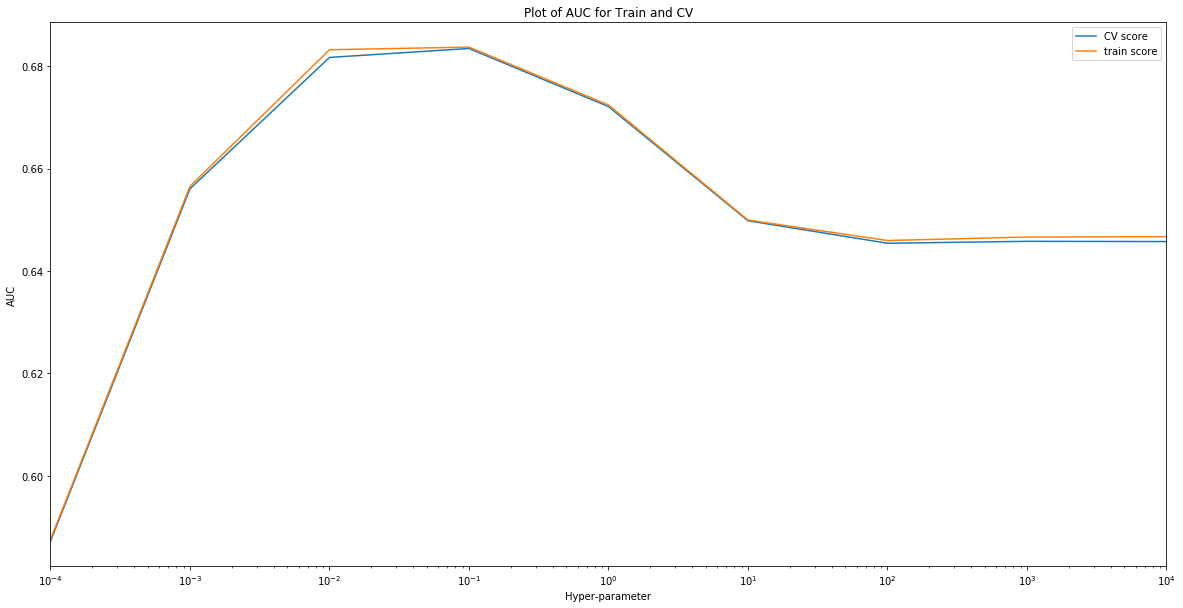

The optimal hyperparamter is  0.1
*********************************************************************************************************************
AUC for Train data is   0.6841479960753709 

AUC for the Test data is   0.6954545111106074 



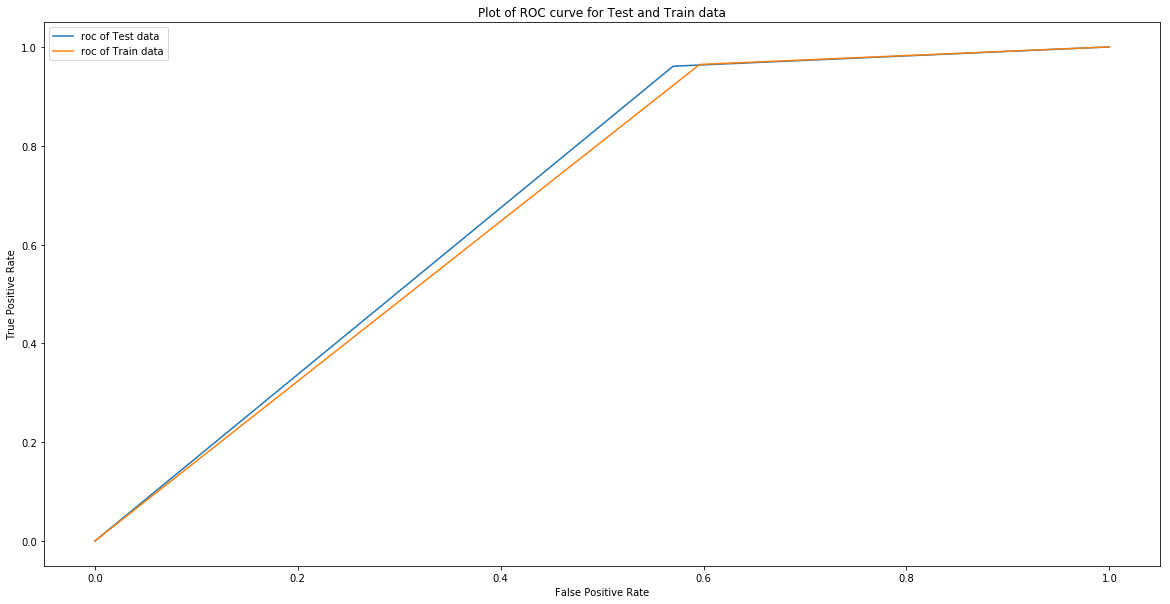

True positive rate = 96.09727164887308
True negative rate = 42.99363057324841


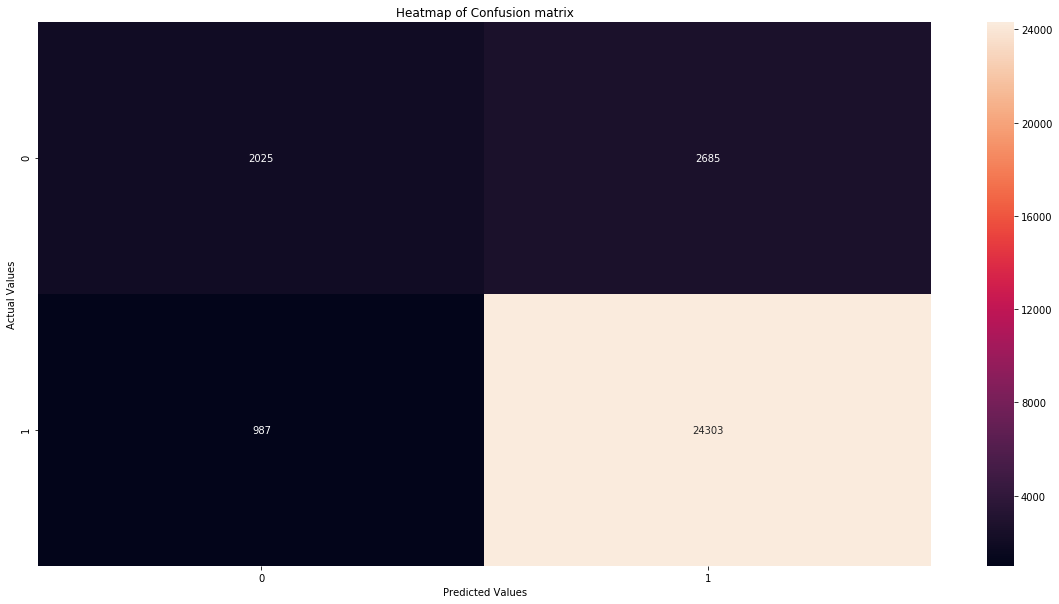

In [43]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(np.array(avgW2VTrain), AmazonReviewDataSampledTrain['Score'],'linear','l2',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(np.array(avgW2VTrain),AmazonReviewDataSampledTrain['Score'],np.array(avgW2VTest),AmazonReviewDataSampledTest['Score'],optimal_alpha,'l2','linear')
table2.add_row(['AvgW2V','Linear','L2',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

<b> Linear SVM using L1 penalty

For alpha = 0.0001 , auc for train data = 0.5929843317974315 and auc for cv = 0.5929357064275749 
For alpha = 0.001 , auc for train data = 0.6605044190611309 and auc for cv = 0.6591707395865773 
For alpha = 0.01 , auc for train data = 0.6781131601700331 and auc for cv = 0.677415487913016 
For alpha = 0.1 , auc for train data = 0.6167637147184859 and auc for cv = 0.6170505993733122 
For alpha = 1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 100 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1000 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10000 , auc for train data = 0.5 and auc for cv = 0.5 


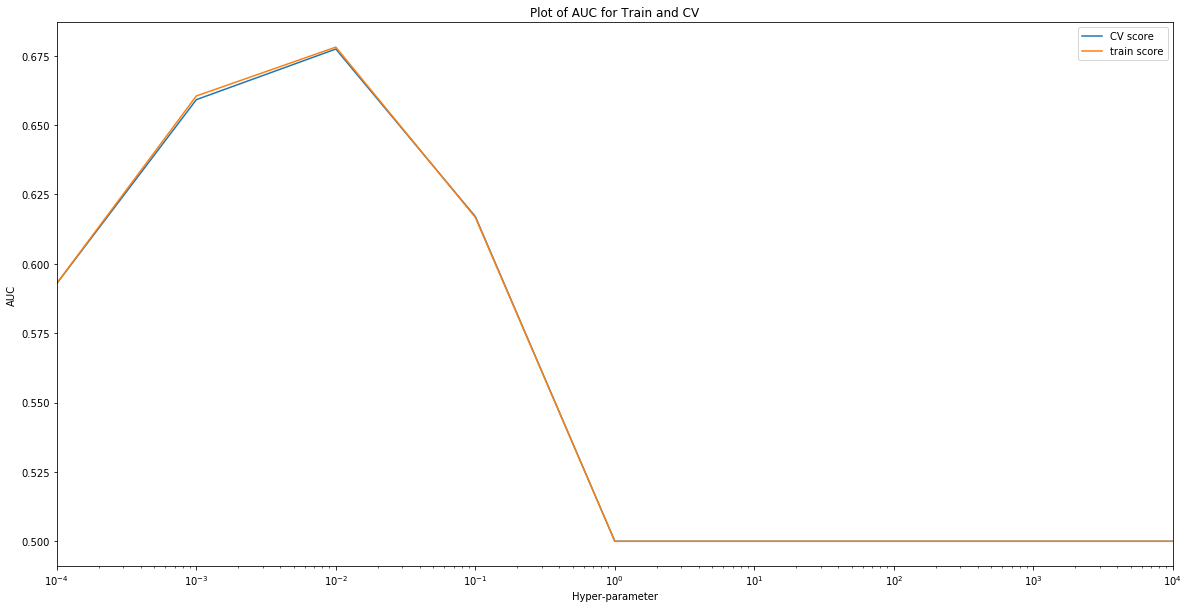

The optimal hyperparamter is  0.01
*********************************************************************************************************************
AUC for Train data is   0.6789600056991312 

AUC for the Test data is   0.6890859658534251 



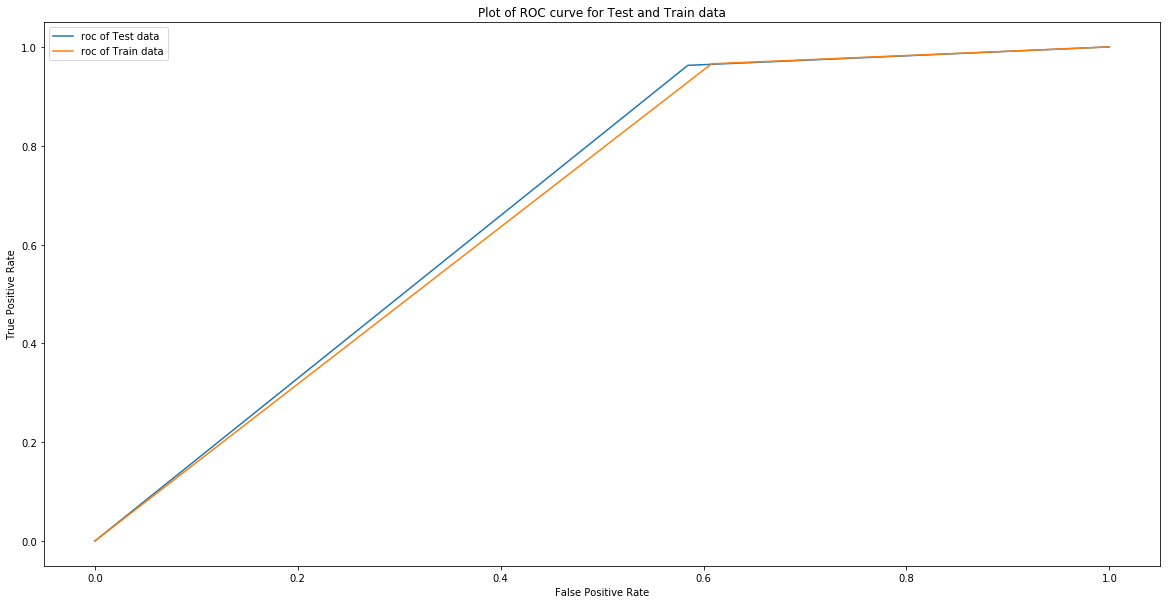

True positive rate = 96.26729932779755
True negative rate = 41.54989384288748


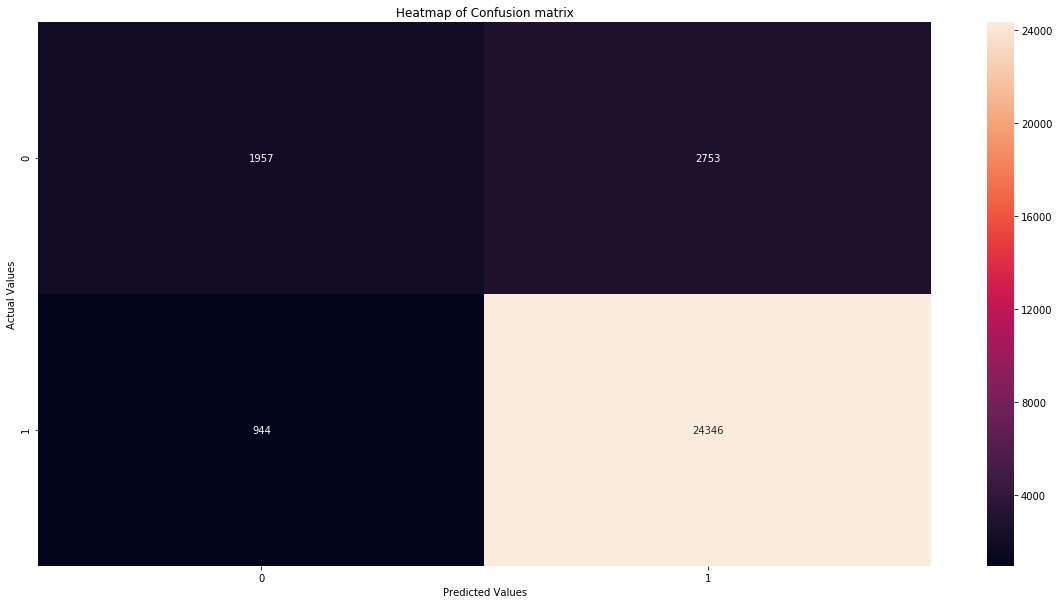

In [44]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(np.array(avgW2VTrain), AmazonReviewDataSampledTrain['Score'],'linear','l1',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(np.array(avgW2VTrain),AmazonReviewDataSampledTrain['Score'],np.array(avgW2VTest),AmazonReviewDataSampledTest['Score'],optimal_alpha,'l1','linear')
table2.add_row(['AvgW2V','Linear','L1',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

<b> Linear SVM using L2 penalty

For alpha = 0.0001 , auc for train data = 0.5299088031284561 and auc for cv = 0.5293415633371799 
For alpha = 0.001 , auc for train data = 0.5927954643165914 and auc for cv = 0.592886806345372 
For alpha = 0.01 , auc for train data = 0.6268178999754144 and auc for cv = 0.6268139459912982 
For alpha = 0.1 , auc for train data = 0.6291371805411338 and auc for cv = 0.6285869810492668 
For alpha = 1 , auc for train data = 0.6158638505951375 and auc for cv = 0.6150638816952945 
For alpha = 10 , auc for train data = 0.5835822118468388 and auc for cv = 0.5839072223079028 
For alpha = 100 , auc for train data = 0.5799891744971926 and auc for cv = 0.5803112125810475 
For alpha = 1000 , auc for train data = 0.5814433460738592 and auc for cv = 0.5816647067240244 
For alpha = 10000 , auc for train data = 0.5814549084405068 and auc for cv = 0.580635204383969 


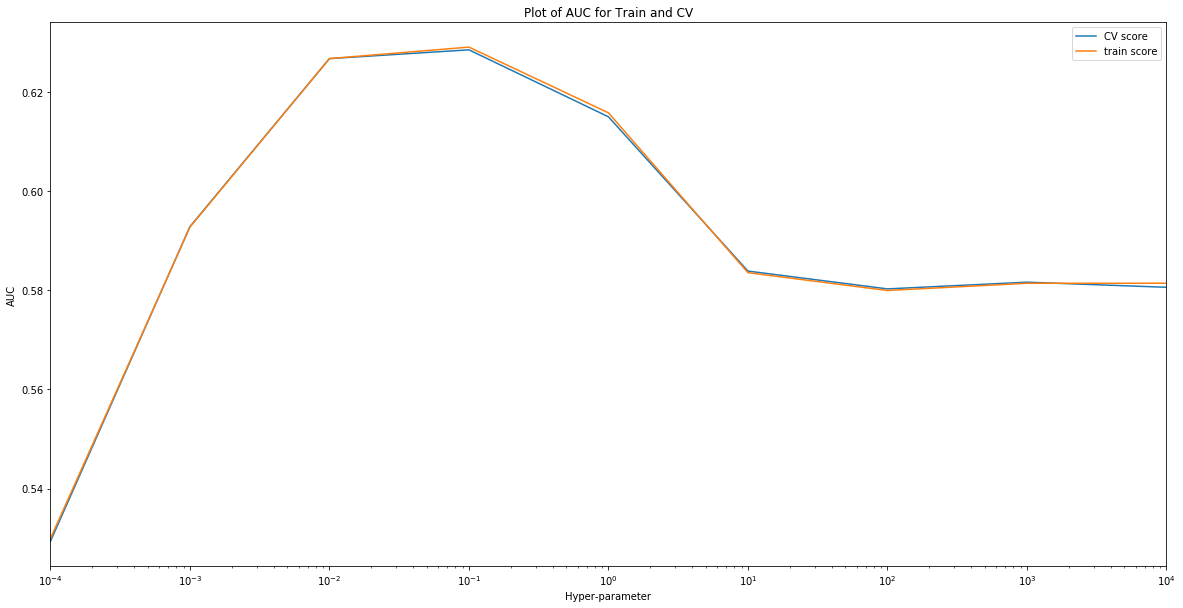

The optimal hyperparamter is  0.1
*********************************************************************************************************************
AUC for Train data is   0.629829986712821 

AUC for the Test data is   0.640552016985138 



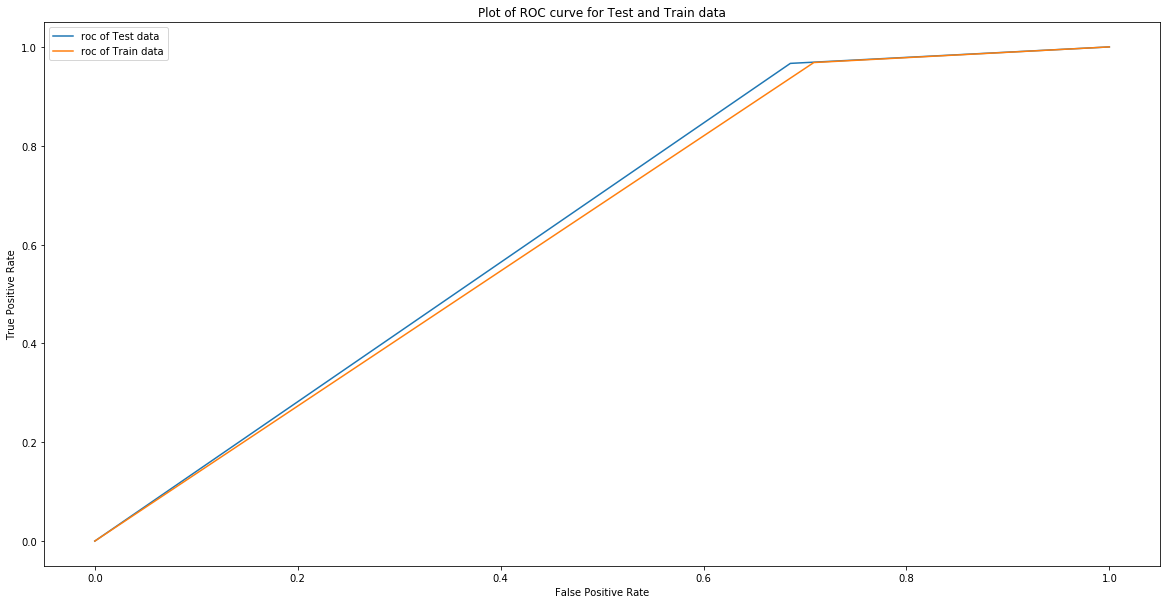

True positive rate = 96.66666666666667
True negative rate = 31.443736730360932


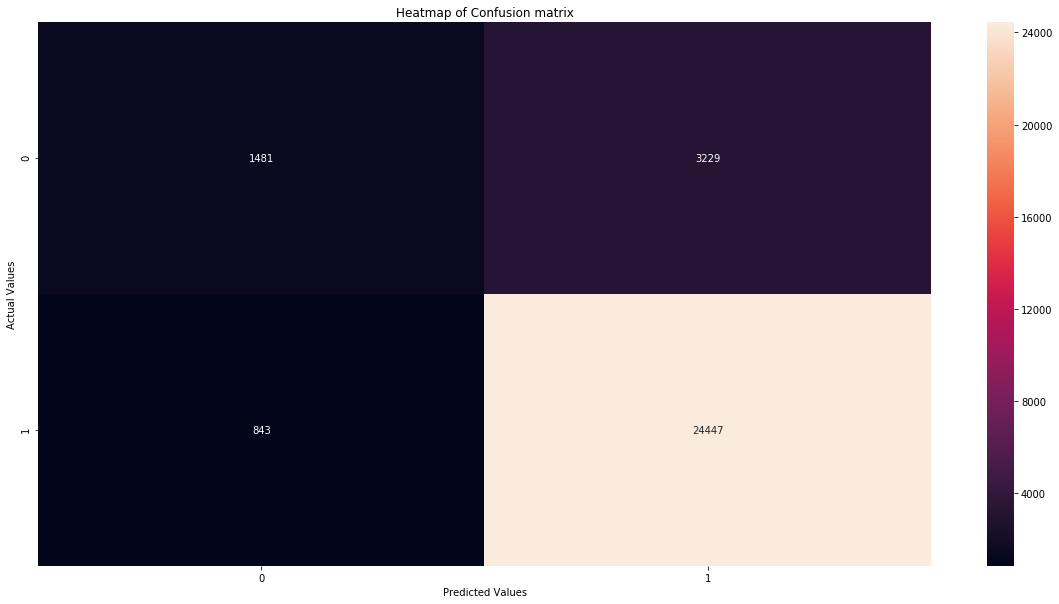

In [45]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(np.array(tfidfw2vTrain), AmazonReviewDataSampledTrain['Score'],'linear','l2',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(np.array(tfidfw2vTrain),AmazonReviewDataSampledTrain['Score'],np.array(tfidfw2vTest),AmazonReviewDataSampledTest['Score'],optimal_alpha,'l2','linear')
table2.add_row(['TFIDF W2V','Linear','L2',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

<b> Linear SVM using L1 penalty

For alpha = 0.0001 , auc for train data = 0.5345399941741866 and auc for cv = 0.5348341822513294 
For alpha = 0.001 , auc for train data = 0.593777976691607 and auc for cv = 0.5932854765502513 
For alpha = 0.01 , auc for train data = 0.624641611818569 and auc for cv = 0.6248970142974059 
For alpha = 0.1 , auc for train data = 0.5600239780689859 and auc for cv = 0.5605500503078231 
For alpha = 1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 100 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1000 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10000 , auc for train data = 0.5 and auc for cv = 0.5 


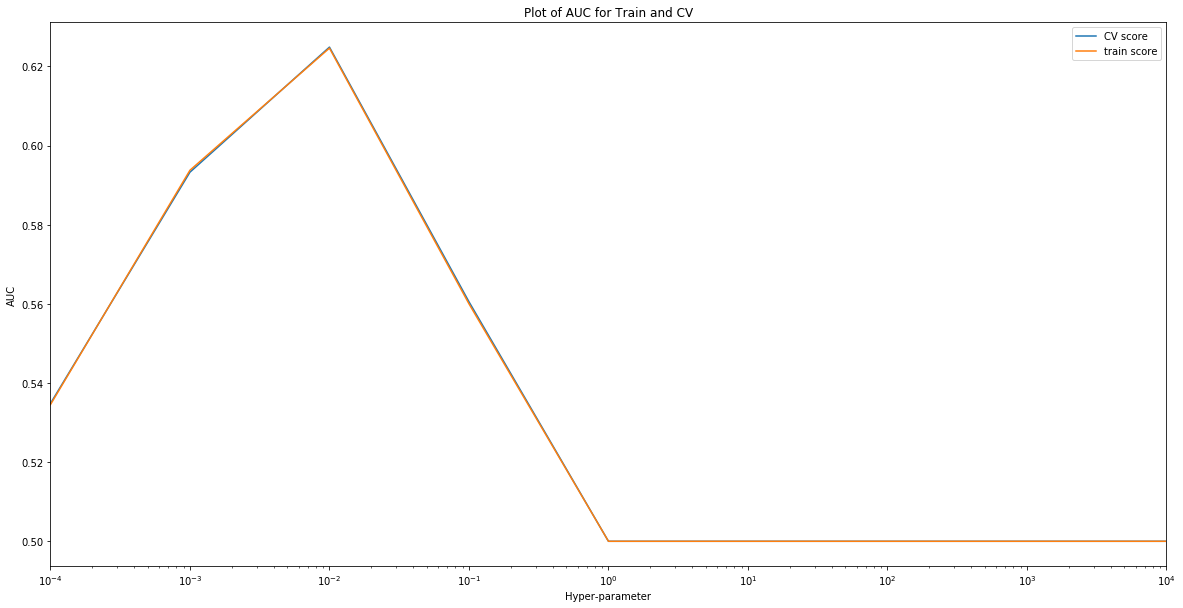

The optimal hyperparamter is  0.01
*********************************************************************************************************************
AUC for Train data is   0.6253413811974005 

AUC for the Test data is   0.6353855782477402 



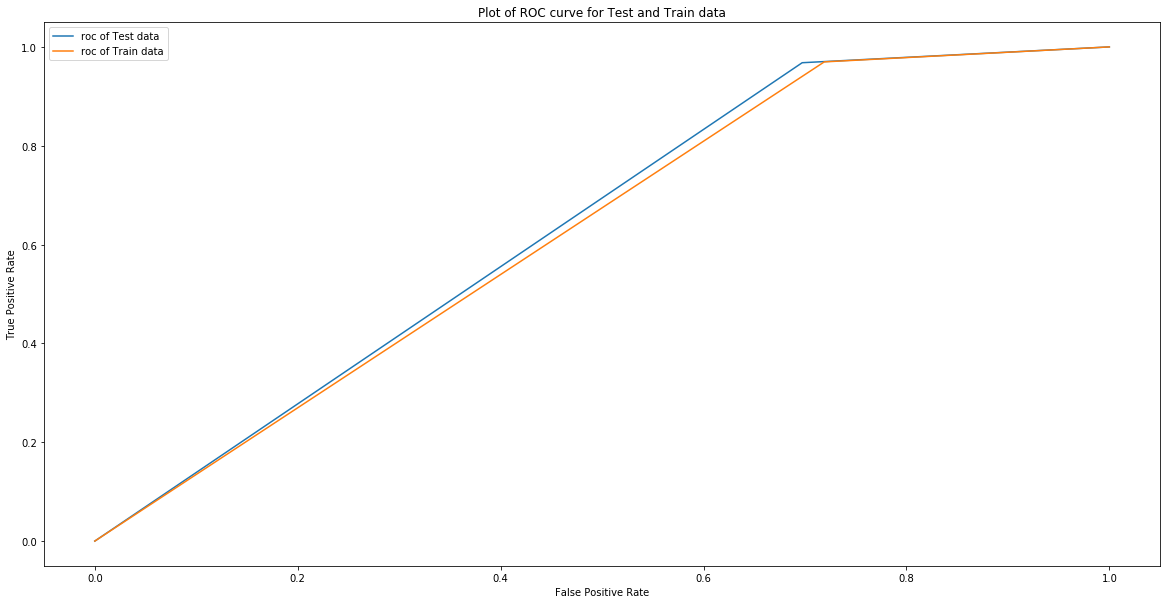

True positive rate = 96.80110715697904
True negative rate = 30.276008492569


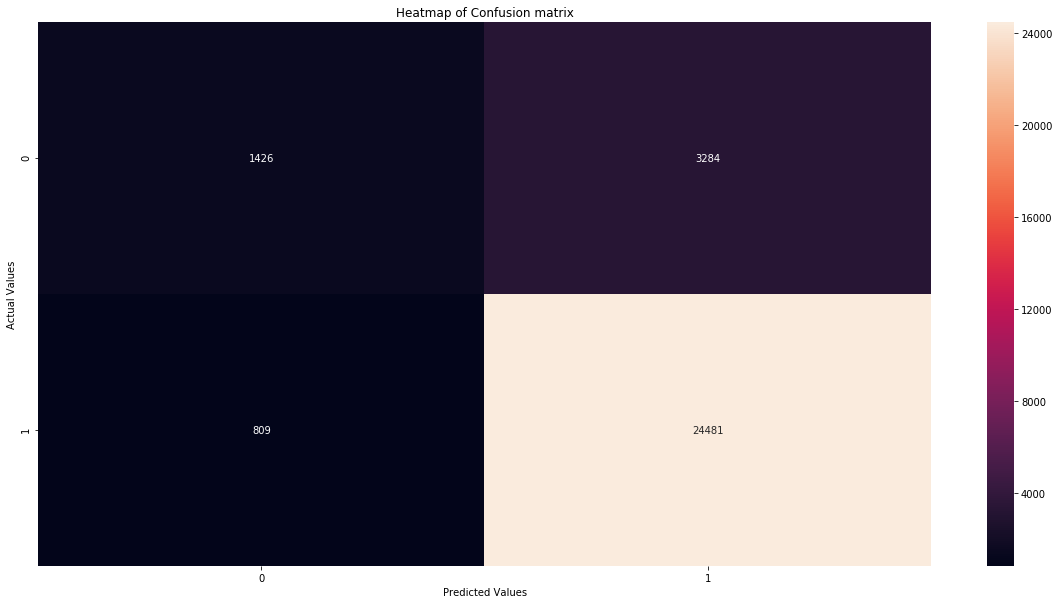

In [46]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(np.array(tfidfw2vTrain), AmazonReviewDataSampledTrain['Score'],'linear','l1',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(np.array(tfidfw2vTrain),AmazonReviewDataSampledTrain['Score'],np.array(tfidfw2vTest),AmazonReviewDataSampledTest['Score'],optimal_alpha,'l1','linear')
table2.add_row(['TFIDF W2V','Linear','L1',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

## [5.2] RBF SVM

Since the train dataset is large, inorder to reduce the time for training, we are taking a train dataset of 40k samples and test dataset of 30k samples

In [15]:
# Pretty table for RBF SVM
table4 = PrettyTable()
table4.field_names = ['Vectorizer', 'Type of SVM','optimal Hyperparameter','AUC','TPR','TNR']

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [16]:
# Performing bag of words vectorization and column standardization for train and test dataset
bagword = CountVectorizer(min_df= 10, max_features= 500)
bowTrain_RBF = bagword.fit_transform(AmazonReviewDataSampledTrain_RBF['Text'])
print('The shape of bag of words for train data is ', bowTrain_RBF.shape)
print('='*117)
bowTest = bagword.transform(AmazonReviewDataSampledTest['Text'])
print('The shape of bag of words for Test data is ', bowTest.shape)
print('='*117)

maxscaler = MaxAbsScaler()
bowTrain_RBF = maxscaler.fit_transform(bowTrain_RBF)
bowTest = maxscaler.transform(bowTest)

The shape of bag of words for train data is  (40000, 500)
The shape of bag of words for Test data is  (30000, 500)


For alpha = 0.0001 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 0.001 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 0.01 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 0.1 , auc for train data = 0.5001003411599438 and auc for cv = 0.5 
For alpha = 1 , auc for train data = 0.7069301420439666 and auc for cv = 0.7032141218248373 
For alpha = 10 , auc for train data = 0.8295328334421945 and auc for cv = 0.8192548952997017 
For alpha = 100 , auc for train data = 0.8472957888408106 and auc for cv = 0.8271275142899731 
For alpha = 1000 , auc for train data = 0.852368367436143 and auc for cv = 0.8242587018552012 
For alpha = 10000 , auc for train data = 0.8711897536422296 and auc for cv = 0.8254512910911063 


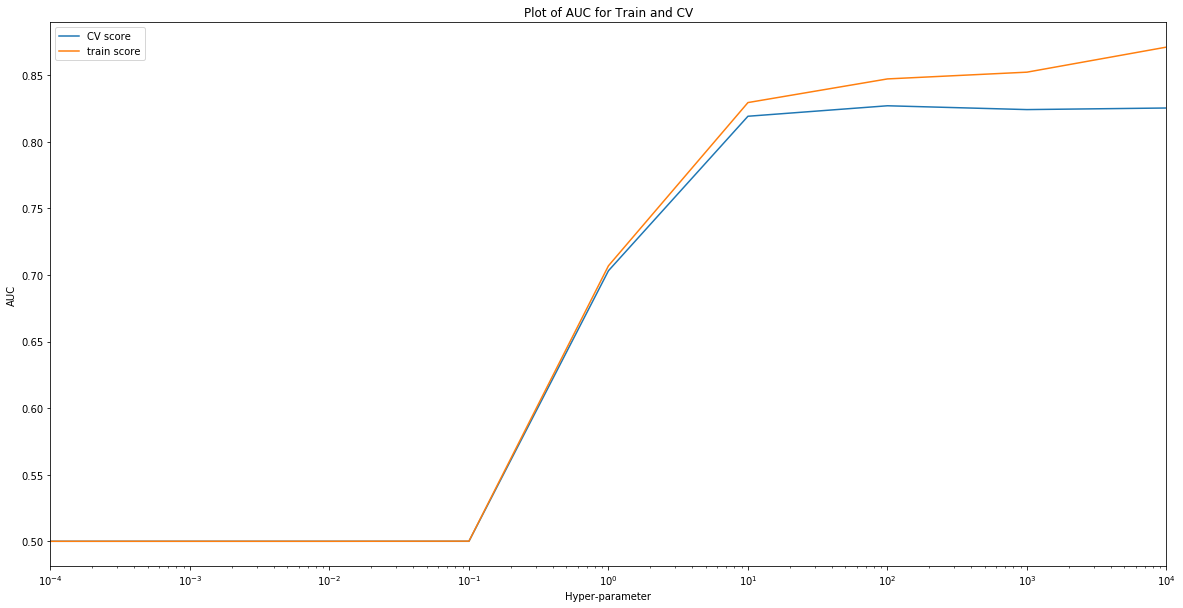

The optimal hyperparamter is  100
*********************************************************************************************************************
AUC for Train data is   0.8453237707960912 

AUC for the Test data is   0.8310137437571307 



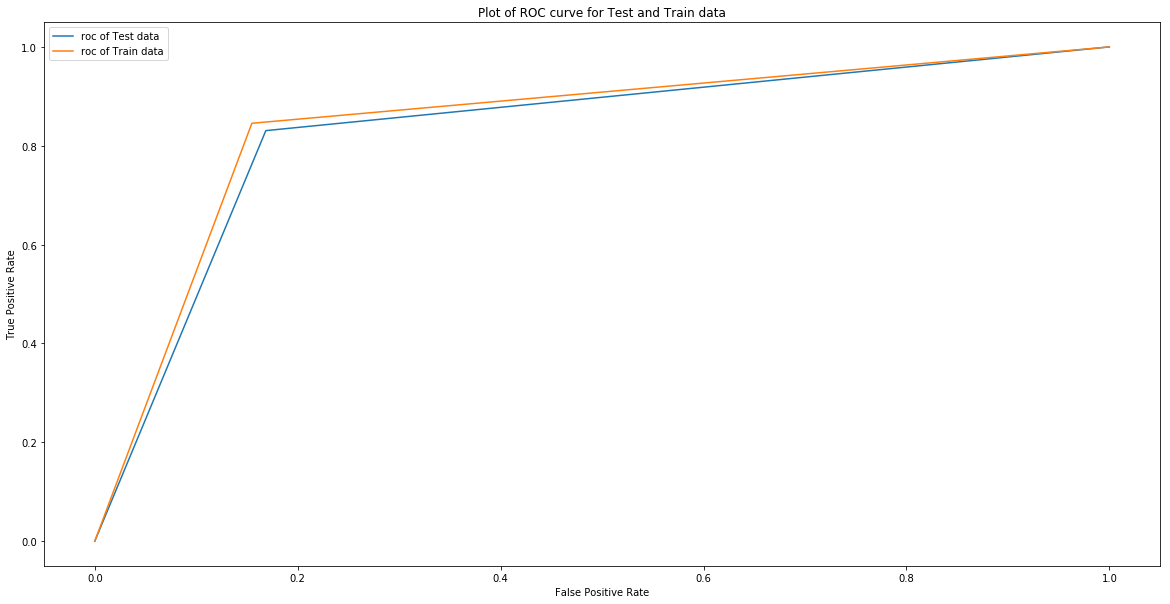

True positive rate = 83.06049822064057
True negative rate = 83.14225053078556


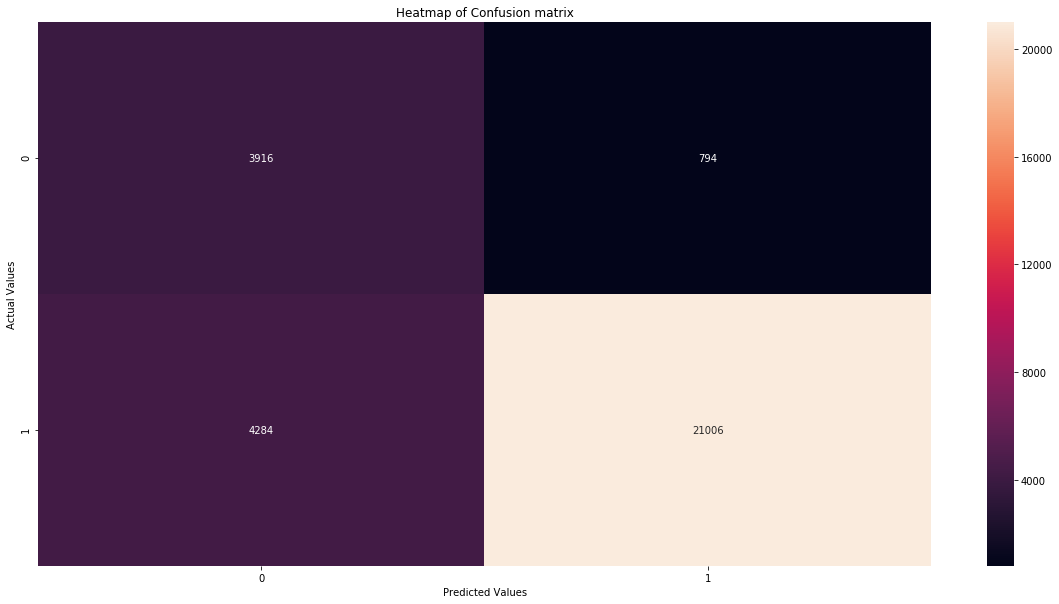

In [19]:
# Please write all the code with proper documentation

print('='*117)
optimal_alpha = clf(bowTrain_RBF, AmazonReviewDataSampledTrain_RBF['Score'],'rbf')
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrain_RBF,AmazonReviewDataSampledTrain_RBF['Score'],bowTest,AmazonReviewDataSampledTest['Score'],optimal_alpha,svc='rbf')
table4.add_row(['Bag of Words','rbf',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [20]:
#Performing TFIDF for train and test dataset
tfidfVec_RBF = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features= 500)
tfidfVec_RBF.fit(AmazonReviewDataSampledTrain_RBF['Text'])
print("some sample features(unique words in the corpus)",tfidfVec_RBF.get_feature_names()[0:10])
print('='*117)

tfidfTrain_RBF = tfidfVec_RBF.transform(AmazonReviewDataSampledTrain_RBF['Text'])
print("the type of count vectorizer ",type(tfidfTrain_RBF))
print("the shape of out text TFIDF Train vectorizer ",tfidfTrain_RBF.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidfTrain_RBF.get_shape()[1])
print('*'*117)
tfidfTest = tfidfVec_RBF.transform(AmazonReviewDataSampledTest['Text'])
print("the shape of out text TFIDF Test vectorizer ",tfidfTest.get_shape())
print('='*117)


maxscaler = MaxAbsScaler()
tfidfTrain_RBF = maxscaler.fit_transform(tfidfTrain_RBF)
tfidfTest = maxscaler.transform(tfidfTest)

some sample features(unique words in the corpus) ['abl', 'absolut', 'actual', 'ad', 'add', 'addict', 'addit', 'ago', 'almond', 'almost']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF Train vectorizer  (40000, 500)
the number of unique words including both unigrams and bigrams  500
*********************************************************************************************************************
the shape of out text TFIDF Test vectorizer  (30000, 500)


For alpha = 0.0001 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 0.001 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 0.01 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 0.1 , auc for train data = 0.5012941153141738 and auc for cv = 0.5023659305993691 
For alpha = 1 , auc for train data = 0.8154302301801525 and auc for cv = 0.8024009814230635 
For alpha = 10 , auc for train data = 0.8462306763683207 and auc for cv = 0.827034025540242 
For alpha = 100 , auc for train data = 0.8531845677092217 and auc for cv = 0.8286855847395836 
For alpha = 1000 , auc for train data = 0.8662533584762135 and auc for cv = 0.8262791207678942 
For alpha = 10000 , auc for train data = 0.9440395618105358 and auc for cv = 0.8295712272099357 


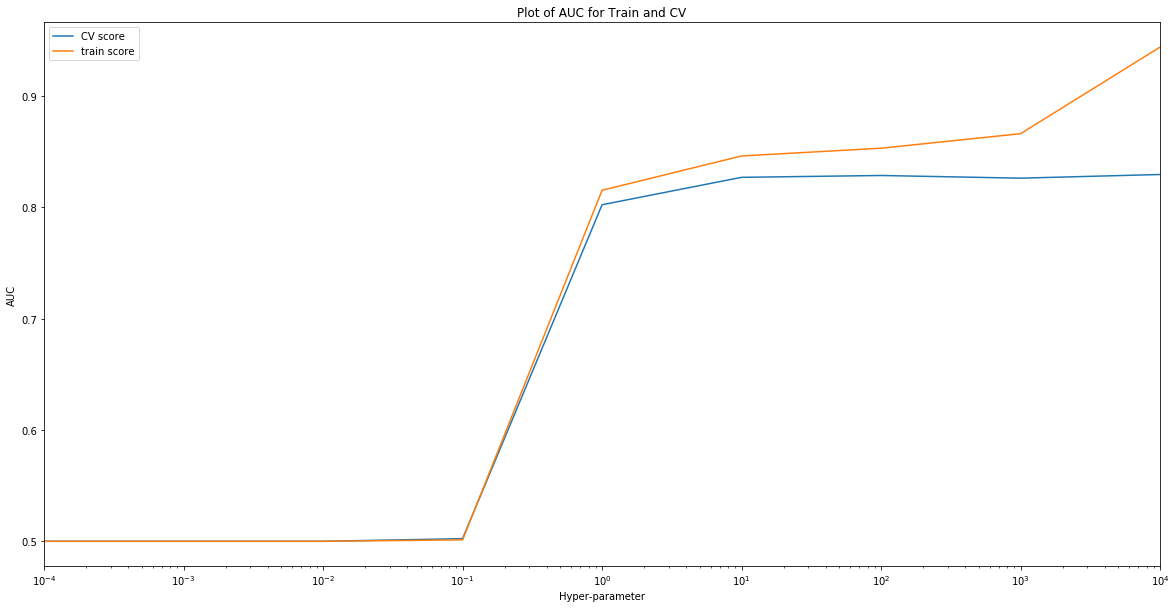

The optimal hyperparamter is  10000
*********************************************************************************************************************
AUC for Train data is   0.9421201875574694 

AUC for the Test data is   0.8387191382510647 



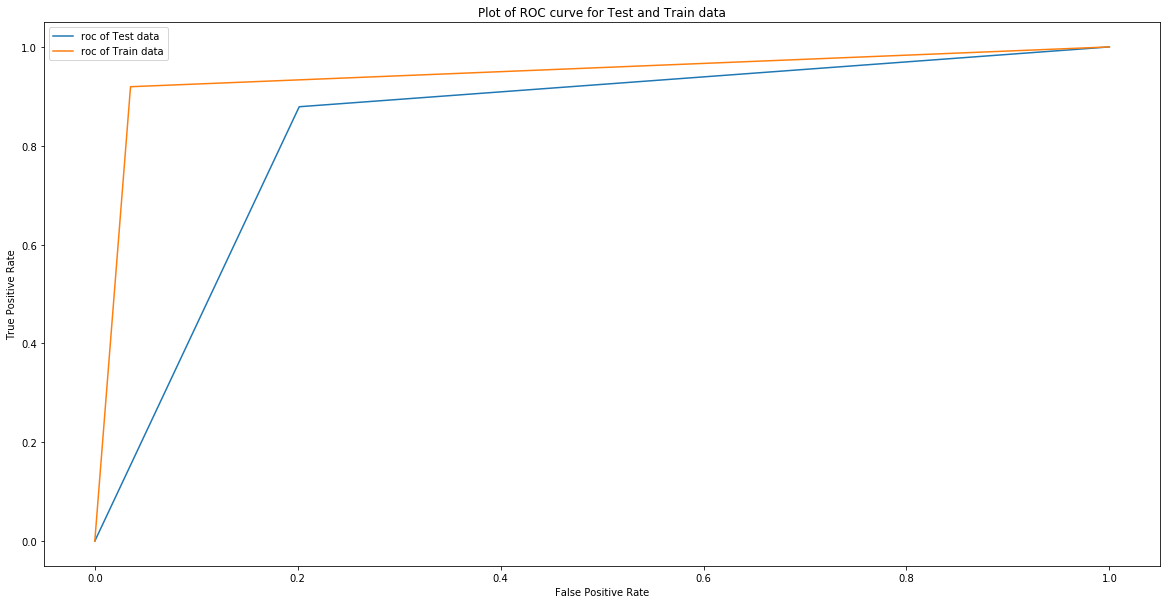

True positive rate = 87.8924476077501
True negative rate = 79.85138004246285


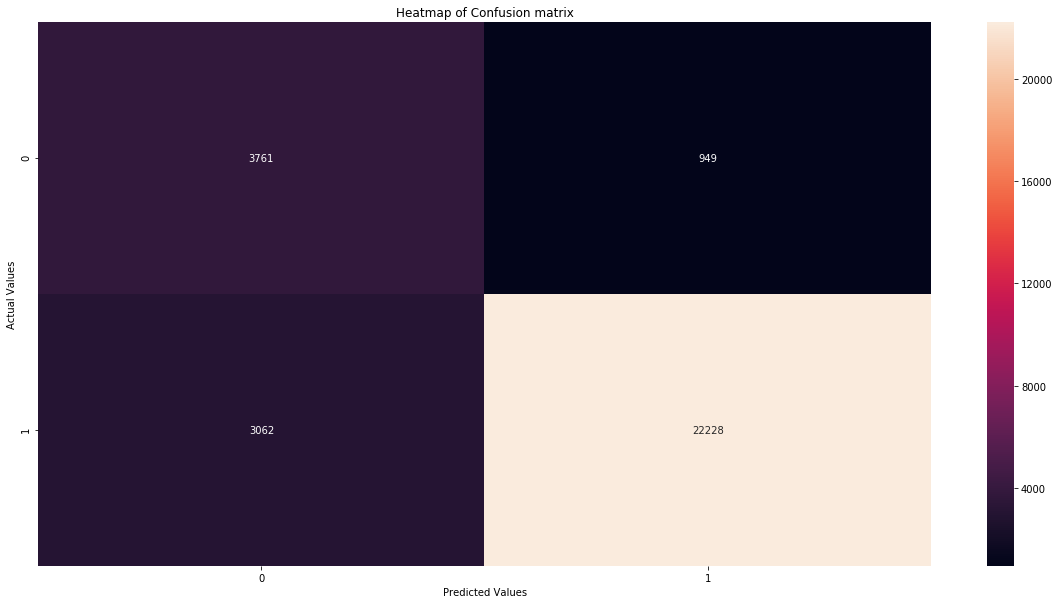

In [22]:
# Please write all the code with proper documentation

print('='*117)
optimal_alpha = clf(tfidfTrain_RBF, AmazonReviewDataSampledTrain_RBF['Score'],'rbf')
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrain_RBF,AmazonReviewDataSampledTrain_RBF['Score'],tfidfTest,AmazonReviewDataSampledTest['Score'],optimal_alpha,svc='rbf')
table4.add_row(['TFIDF','rbf',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [30]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTrain_RBF = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTrain_RBF['Text'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTrain_RBF.append(sent_vec)
#print(len(avgW2VTrain))
print('The shape of avgerage word to vector for Train data  is ','(',len(avgW2VTrain_RBF),',',len(avgW2VTrain_RBF[0]),')')
scale = StandardScaler()
avgW2VTrain_RBF = scale.fit_transform(avgW2VTrain_RBF)


The shape of avgerage word to vector for Train data  is  ( 40000 , 50 )


In [31]:
# average Word2Vec
# compute average word2vec for each review.
avgW2VTest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(AmazonReviewDataSampledTest['Text'].values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgW2VTest.append(sent_vec)
print('The shape of avgerage word to vector for Test data  is ','(',len(avgW2VTest),',',len(avgW2VTest[0]),')')
avgW2VTest = scale.transform(avgW2VTest)


The shape of avgerage word to vector for Test data  is  ( 30000 , 50 )


For alpha = 0.0001 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 0.001 , auc for train data = 0.7329828243554839 and auc for cv = 0.7407139664744304 
For alpha = 0.01 , auc for train data = 0.8068139561561775 and auc for cv = 0.8123644323303466 
For alpha = 0.1 , auc for train data = 0.8437164788039464 and auc for cv = 0.8290131579269424 
For alpha = 1 , auc for train data = 0.9011657875987118 and auc for cv = 0.8267902275260561 
For alpha = 10 , auc for train data = 0.9714530469939084 and auc for cv = 0.7825940045985926 
For alpha = 100 , auc for train data = 0.997796650463195 and auc for cv = 0.7252779152525529 
For alpha = 1000 , auc for train data = 0.9988043045037864 and auc for cv = 0.715756298098834 
For alpha = 10000 , auc for train data = 0.9988043045037864 and auc for cv = 0.715756298098834 


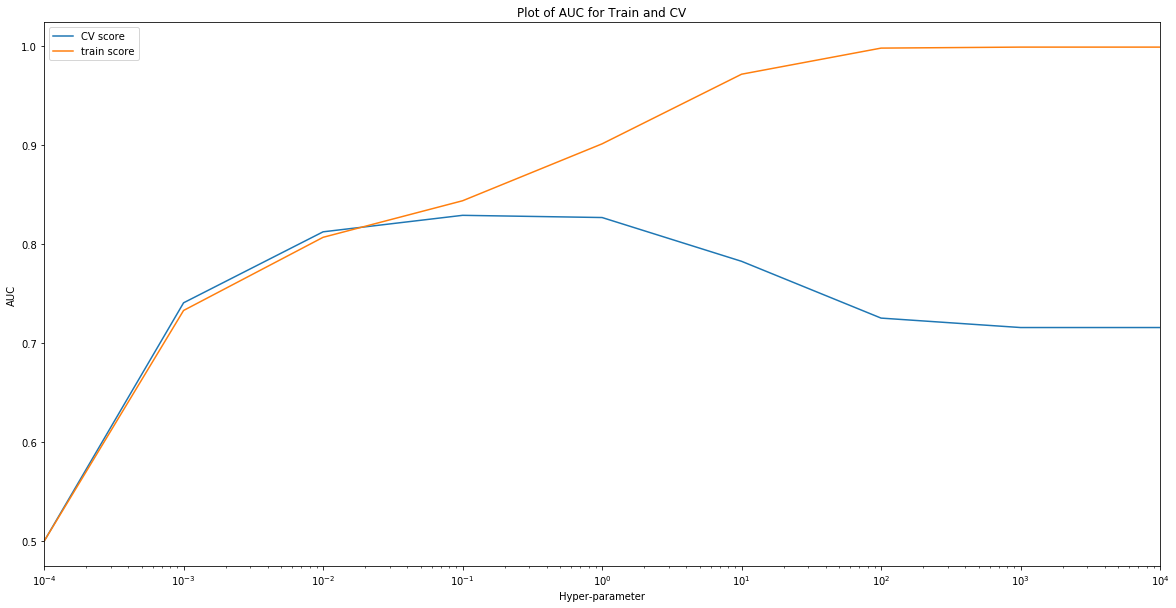

The optimal hyperparamter is  0.1
*********************************************************************************************************************
AUC for Train data is   0.845711469523815 

AUC for the Test data is   0.8231608878411699 



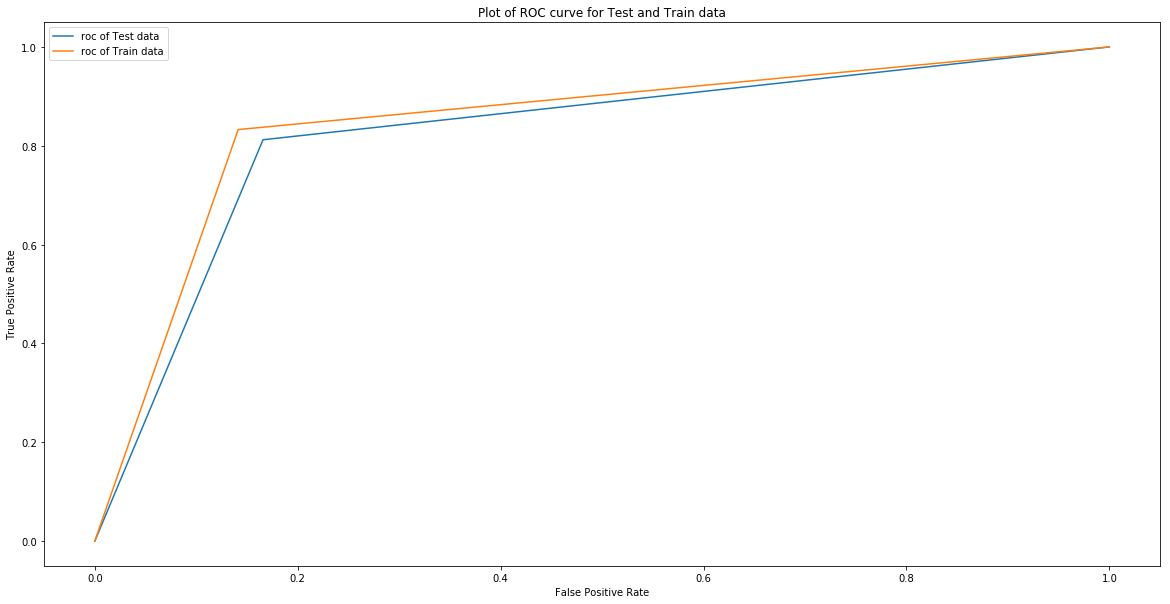

True positive rate = 81.2139185448794
True negative rate = 83.41825902335457


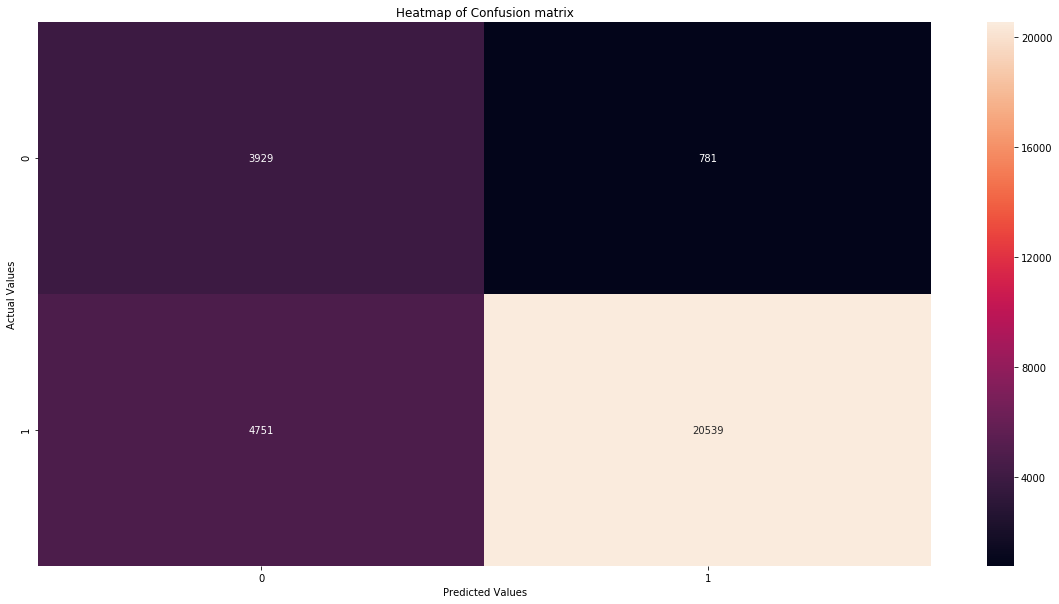

In [37]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation

print('='*117)
optimal_alpha = clf(avgW2VTrain_RBF, AmazonReviewDataSampledTrain_RBF['Score'],'rbf')
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrain_RBF,AmazonReviewDataSampledTrain_RBF['Score'],avgW2VTest,AmazonReviewDataSampledTest['Score'],optimal_alpha,svc='rbf')
table4.add_row(['avgW2V','rbf',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(AmazonReviewDataSampledTrain['Text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2vTrain_RBF = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTrain_RBF['Text'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTrain_RBF.append(sent_vec)
    row += 1
print('The shape of avgerage word to vector for Test data  is ','(',len(tfidfw2vTrain_RBF),',',len(tfidfw2vTrain_RBF[0]),')')



The shape of avgerage word to vector for Test data  is  ( 40000 , 50 )


In [35]:

tfidfw2vTest = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(AmazonReviewDataSampledTest['Text'], mininterval= 1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2vTest.append(sent_vec)
    row += 1
print('The shape of avgerage word to vector for Test data  is ','(',len(tfidfw2vTest),',',len(tfidfw2vTest[0]),')')


The shape of avgerage word to vector for Test data  is  ( 30000 , 50 )


In [36]:
scale = StandardScaler()
tfidfw2vTrain_RBF = scale.fit_transform(tfidfw2vTrain_RBF)
tfidfw2vTest = scale.transform(tfidfw2vTest)

For alpha = 0.0001 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 0.001 , auc for train data = 0.6659863945374942 and auc for cv = 0.6773588644844786 
For alpha = 0.01 , auc for train data = 0.7661899487331265 and auc for cv = 0.7623215474240759 
For alpha = 0.1 , auc for train data = 0.8167566676878841 and auc for cv = 0.7882392367576784 
For alpha = 1 , auc for train data = 0.8820999372327747 and auc for cv = 0.7947126997659271 
For alpha = 10 , auc for train data = 0.9622088648455843 and auc for cv = 0.7670805943807537 
For alpha = 100 , auc for train data = 0.9964499043788956 and auc for cv = 0.7074008742213149 
For alpha = 1000 , auc for train data = 0.9986678549925286 and auc for cv = 0.6965862181141049 
For alpha = 10000 , auc for train data = 0.9986863379143088 and auc for cv = 0.6979884122675162 


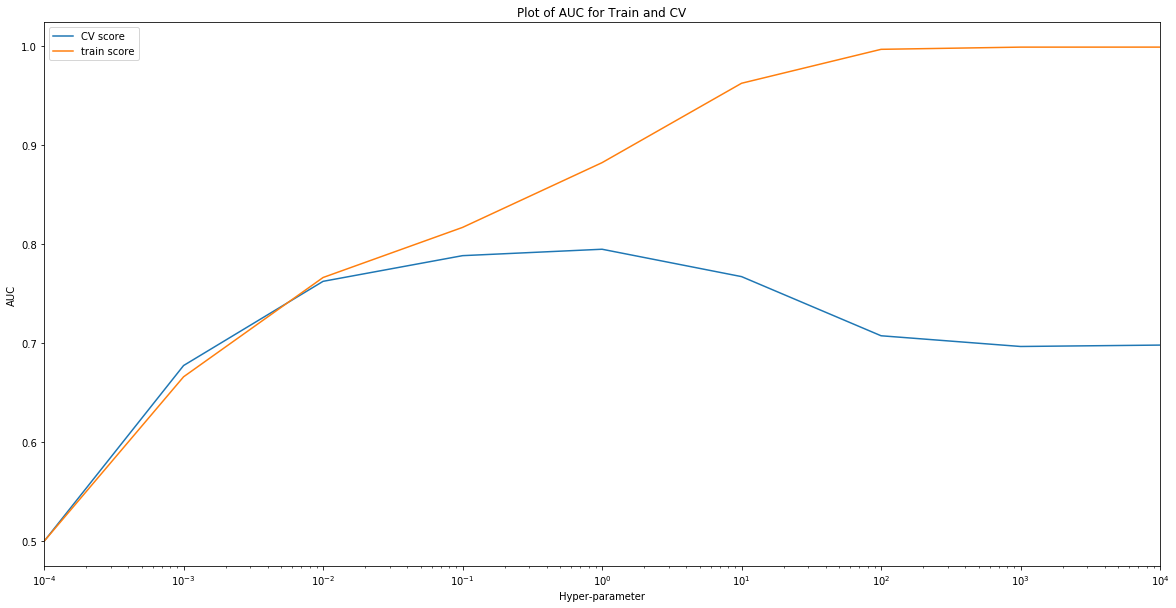

The optimal hyperparamter is  1
*********************************************************************************************************************
AUC for Train data is   0.8805759891410089 

AUC for the Test data is   0.7985719790556928 



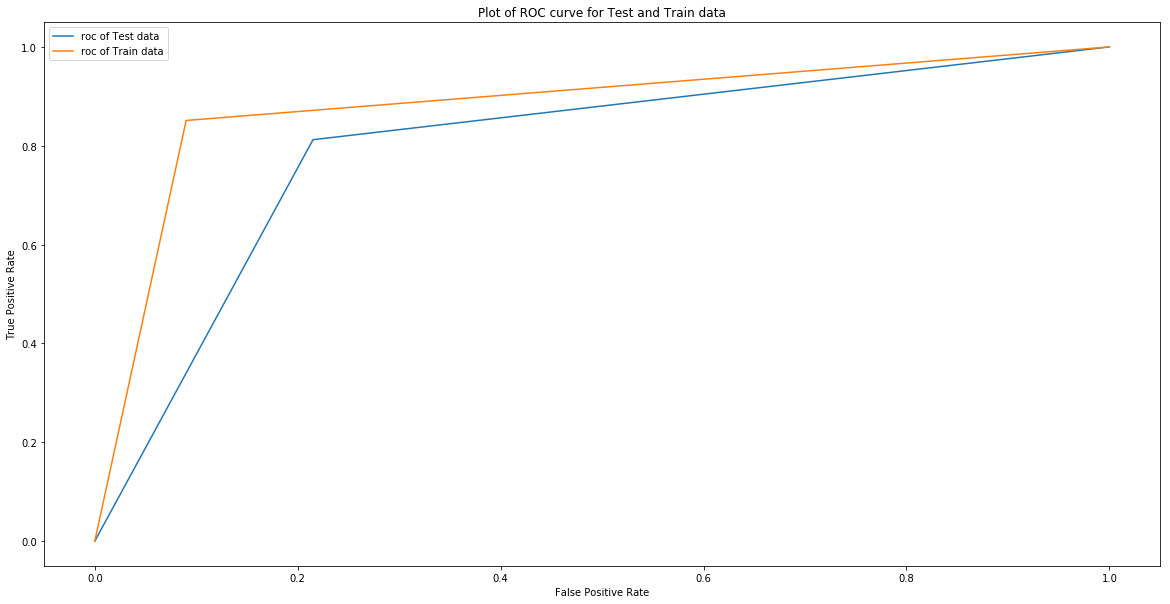

True positive rate = 81.22182680901543
True negative rate = 78.49256900212315


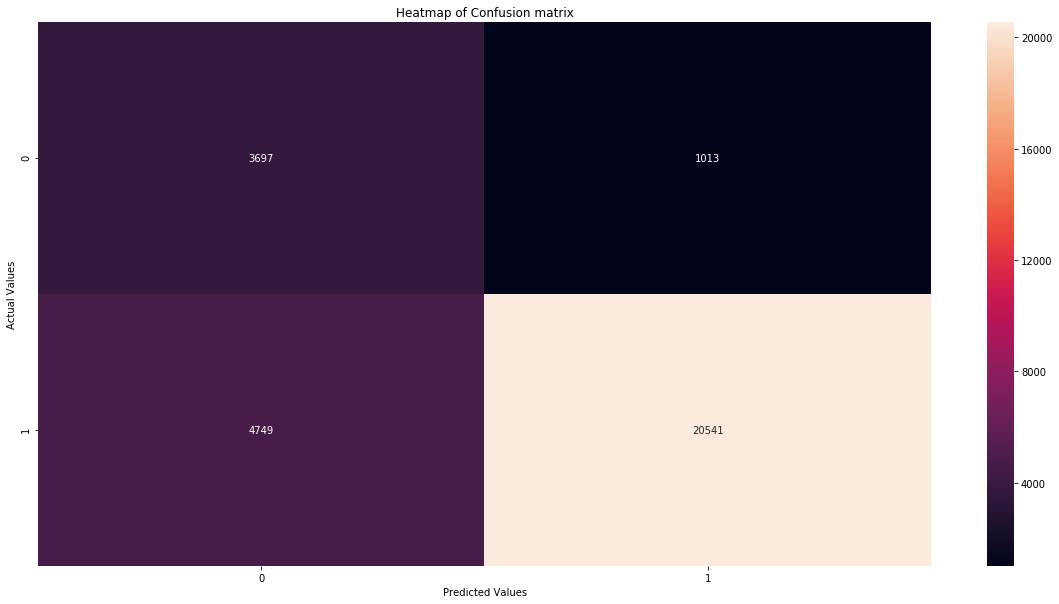

In [38]:
# Please write all the code with proper documentation


print('='*117)
optimal_alpha = clf(tfidfw2vTrain_RBF, AmazonReviewDataSampledTrain_RBF['Score'],'rbf')
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrain_RBF,AmazonReviewDataSampledTrain_RBF['Score'],tfidfw2vTest,AmazonReviewDataSampledTest['Score'],optimal_alpha,svc='rbf')
table4.add_row(['TFIDF W2V','rbf',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

# [6] Feature Engineering to improve the performance of Linear SVM models 

### To improve the performance of Linear SVM using feature engineering. BOW, TFIDF , AVGW2V and TFIDFW2V are calculated for both text review and summary review and merged.

### [6.1]  Applying Linear SVM on BOW

In [48]:
table1 = PrettyTable()
table1.field_names = ['Vectorizer', 'Type of SVM','Penalty','optimal Hyperparameter','AUC','TPR','TNR']

<b> Linear SVM using L2 penalty

In [49]:
#combining the bow for text and summary review
combined_features = FeatureUnion([( 'count_vec', bagofwords),('count_vec1',bagofwordsSum)])

bowTrainFE = combined_features.transform(AmazonReviewDataSampledTrain['Text'] + ' ' +AmazonReviewDataSampledTrain['Summary'])
bowTestFE  = combined_features.transform(AmazonReviewDataSampledTest['Text'] + ' '+ AmazonReviewDataSampledTest['Summary'])


In [50]:
bowTrainFE

<70000x49230 sparse matrix of type '<class 'numpy.int64'>'
	with 4121625 stored elements in Compressed Sparse Row format>

For alpha = 0.0001 , auc for train data = 0.8226230447488498 and auc for cv = 0.7907597064115517 
For alpha = 0.001 , auc for train data = 0.8428186504428921 and auc for cv = 0.8127205738338118 
For alpha = 0.01 , auc for train data = 0.8439383215518548 and auc for cv = 0.814368203768017 
For alpha = 0.1 , auc for train data = 0.7699794742368925 and auc for cv = 0.757884602265358 
For alpha = 1 , auc for train data = 0.6570047410272731 and auc for cv = 0.6540282648039603 
For alpha = 10 , auc for train data = 0.5526825203960009 and auc for cv = 0.5521260476186878 
For alpha = 100 , auc for train data = 0.5413891828594748 and auc for cv = 0.5410638696914871 
For alpha = 1000 , auc for train data = 0.5414077992289362 and auc for cv = 0.5403861404215403 
For alpha = 10000 , auc for train data = 0.5414458602567176 and auc for cv = 0.540961691788523 


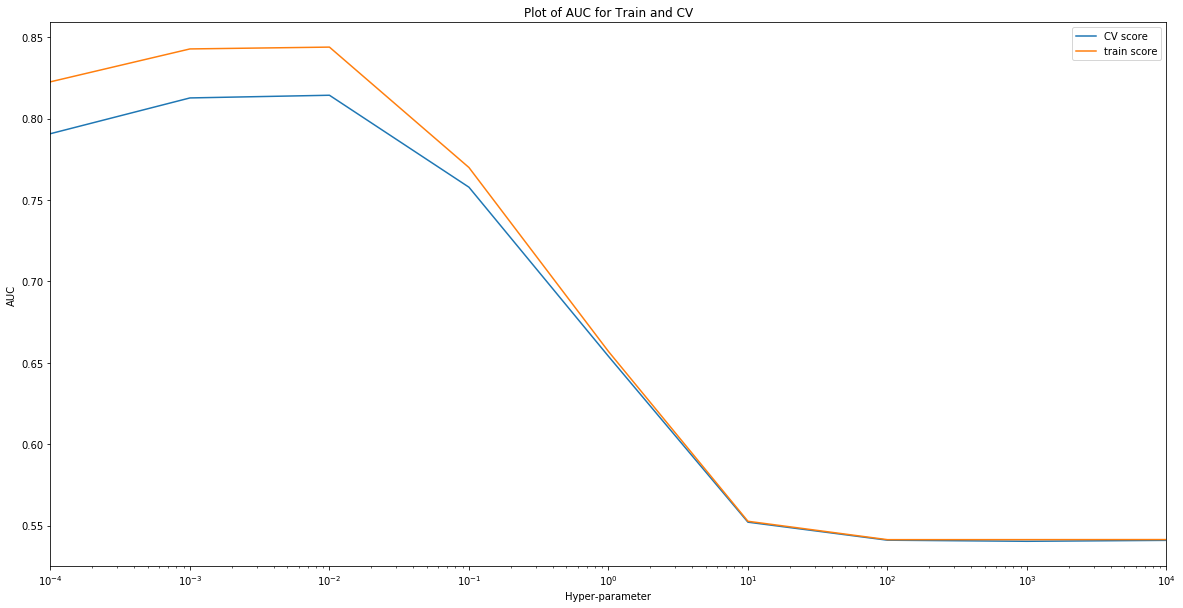

The optimal hyperparamter is  0.01
*********************************************************************************************************************
AUC for Train data is   0.8422342321338172 

AUC for the Test data is   0.8257076511196239 



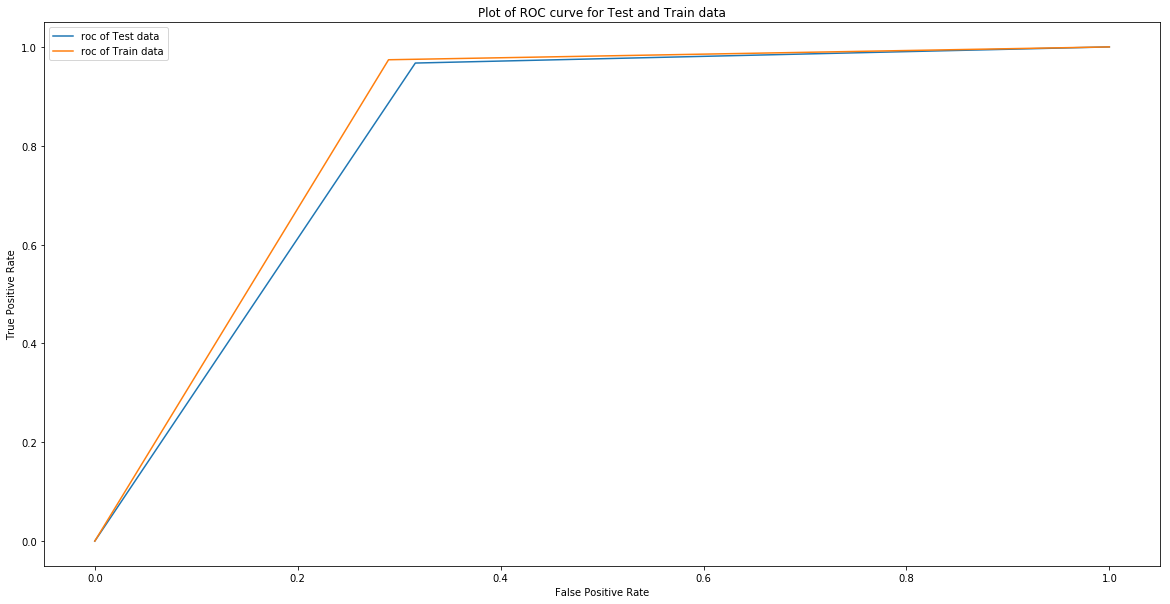

True positive rate = 96.73388691182285
True negative rate = 68.40764331210191
*********************************************************************************************************************
10 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-0.4400	count_vec__unfortun				0.5548	count_vec__delici
	-0.3974	count_vec1__disappoint				0.4560	count_vec__excel
	-0.3974	count_vec__disappoint				0.4162	count_vec__excellent
	-0.3443	count_vec1__disappointed				0.4162	count_vec1__excellent
	-0.3277	count_vec1__worst				0.4034	count_vec1__tasty
	-0.3277	count_vec__worst				0.3854	count_vec__delicious
	-0.2948	count_vec__terribl				0.3854	count_vec1__delicious
	-0.2794	count_vec__horribl				0.3671	count_vec__great
	-0.2708	count_vec1__aw 				0.3671	count_vec1__great
	-0.2708	count_vec__aw  				0.3668	count_vec__best


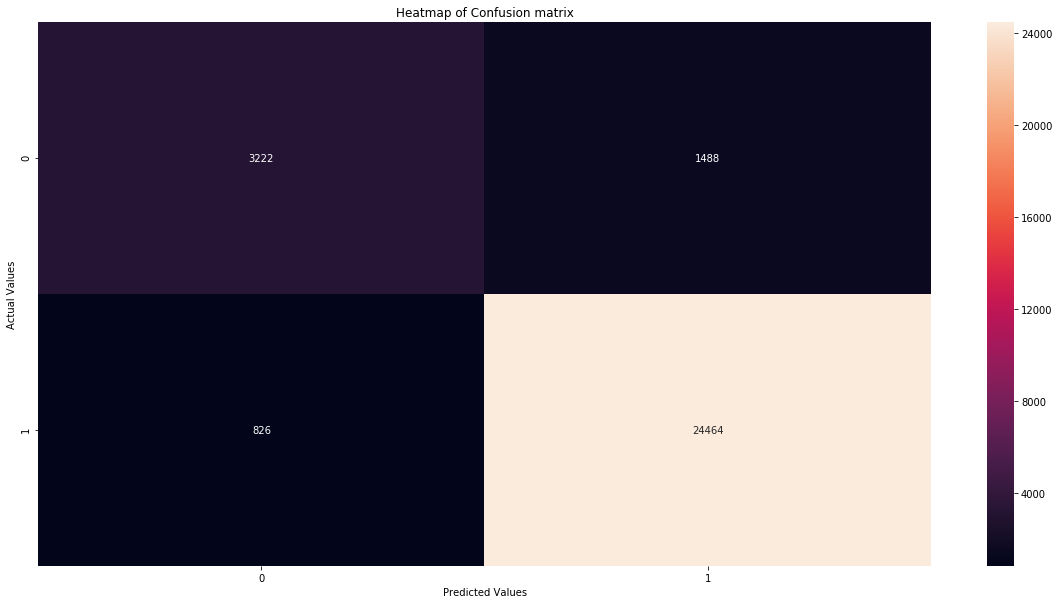

In [51]:

print('='*117)
optimal_alpha = clf(bowTrainFE, AmazonReviewDataSampledTrain['Score'],'linear','l2',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrainFE,AmazonReviewDataSampledTrain['Score'],bowTestFE,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l2','linear')
table1.add_row(['Bag of Words','Linear','L2',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('*'*117)
TopFeatures(10,combined_features,coef[0])
print('='*117)

<b> Linear SVM using L1 penalty

For alpha = 0.0001 , auc for train data = 0.7947061077356363 and auc for cv = 0.7828852000311398 
For alpha = 0.001 , auc for train data = 0.7231148432066684 and auc for cv = 0.718214378375025 
For alpha = 0.01 , auc for train data = 0.5021341265634053 and auc for cv = 0.5021233559786964 
For alpha = 0.1 , auc for train data = 0.5164225131096892 and auc for cv = 0.5168474504496462 
For alpha = 1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 100 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1000 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10000 , auc for train data = 0.5 and auc for cv = 0.5 


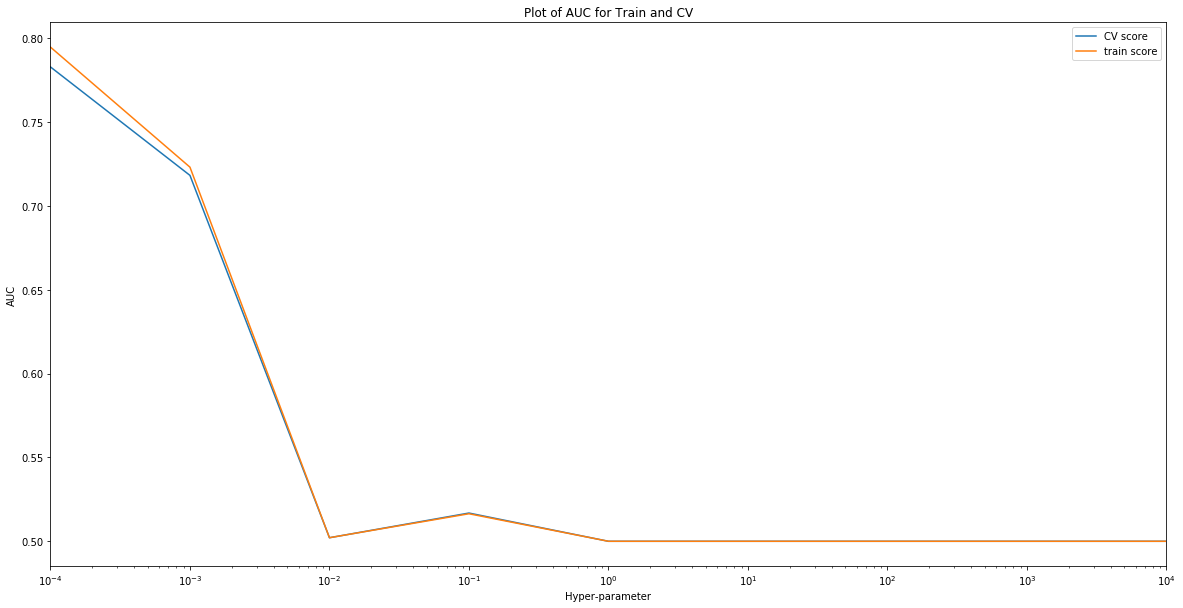

The optimal hyperparamter is  0.0001
*********************************************************************************************************************
AUC for Train data is   0.8000281718417585 

AUC for the Test data is   0.7964926596701196 



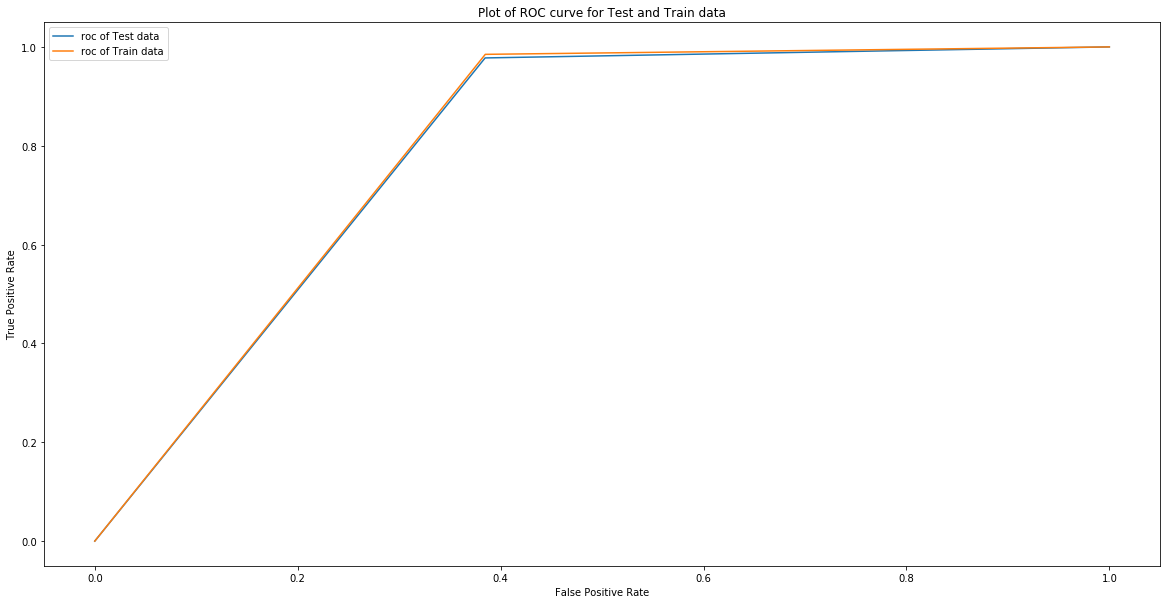

True positive rate = 97.76986951364177
True negative rate = 61.52866242038216
*********************************************************************************************************************
10 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-213.0172	count_vec1__caviar				177.3713	count_vec__delici
	-213.0172	count_vec__caviar				134.7748	count_vec1__tasty
	-202.4517	count_vec1__kitten				133.2661	count_vec__excellent
	-202.4517	count_vec__kitten				133.2661	count_vec1__excellent
	-160.8923	count_vec1__glycol				132.7854	count_vec__amaz
	-160.8923	count_vec__glycol				129.6868	count_vec__excel
	-148.1127	count_vec__unfortun				128.4983	count_vec__happi
	-142.7245	count_vec1__bland				120.3533	count_vec__delicious
	-142.7245	count_vec__bland				120.3533	count_vec1__delicious
	-138.6287	count_vec__berri				114.3269	count_vec__definit


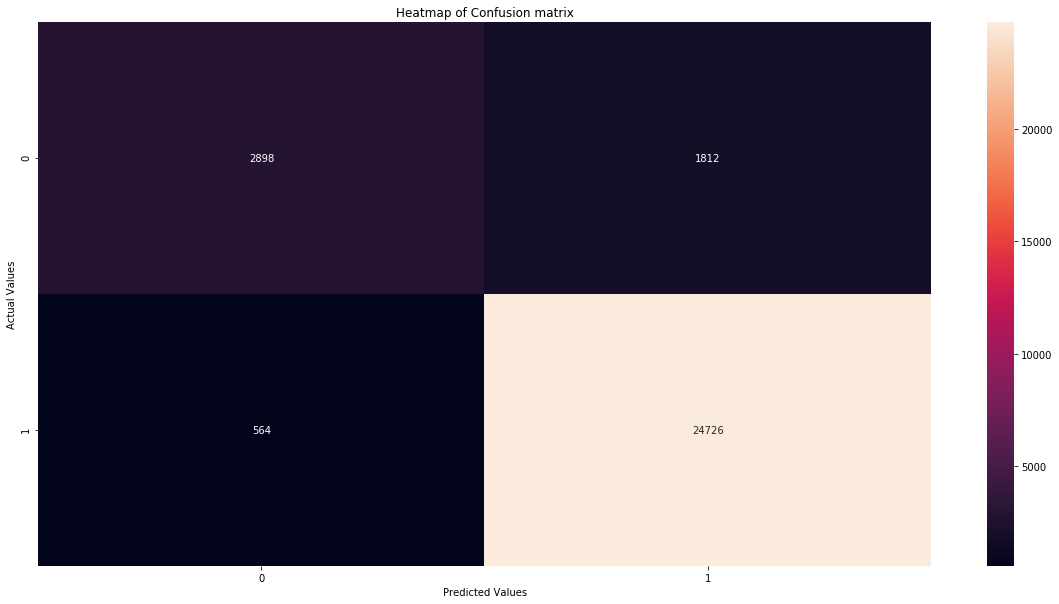

In [52]:

print('='*117)
optimal_alpha = clf(bowTrainFE, AmazonReviewDataSampledTrain['Score'],'linear','l1',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(bowTrainFE,AmazonReviewDataSampledTrain['Score'],bowTestFE,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l1','linear')
table1.add_row(['Bag of Words','Linear','L1',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('*'*117)
TopFeatures(10,(combined_features),coef[0])
print('='*117)

### [6.2]  Applying Linear SVM on TFIDF

In [53]:
# combining the TFIDF of text and summary review
combined_features = FeatureUnion([( 'count_vec', tfidfVec),('count_vec1',tfidfVecSum)])

tfidfTrainFE = combined_features.transform(AmazonReviewDataSampledTrain['Text'] + ' ' +AmazonReviewDataSampledTrain['Summary'])
tfidfTestFE  = combined_features.transform(AmazonReviewDataSampledTest['Text'] + ' '+ AmazonReviewDataSampledTest['Summary'])


<b> Linear SVM using L2 penalty

For alpha = 0.0001 , auc for train data = 0.9446548083450423 and auc for cv = 0.8697253346478231 
For alpha = 0.001 , auc for train data = 0.8516979438671962 and auc for cv = 0.8256140945172585 
For alpha = 0.01 , auc for train data = 0.7369412764534379 and auc for cv = 0.7302819265944043 
For alpha = 0.1 , auc for train data = 0.6803512402003713 and auc for cv = 0.6775840838842001 
For alpha = 1 , auc for train data = 0.6803236402017996 and auc for cv = 0.6771261580984919 
For alpha = 10 , auc for train data = 0.6802711469721879 and auc for cv = 0.6770269878088785 
For alpha = 100 , auc for train data = 0.6801835284649717 and auc for cv = 0.6774462127091325 
For alpha = 1000 , auc for train data = 0.6801788592686744 and auc for cv = 0.6773945468532945 
For alpha = 10000 , auc for train data = 0.6803619388408111 and auc for cv = 0.6770474249018028 


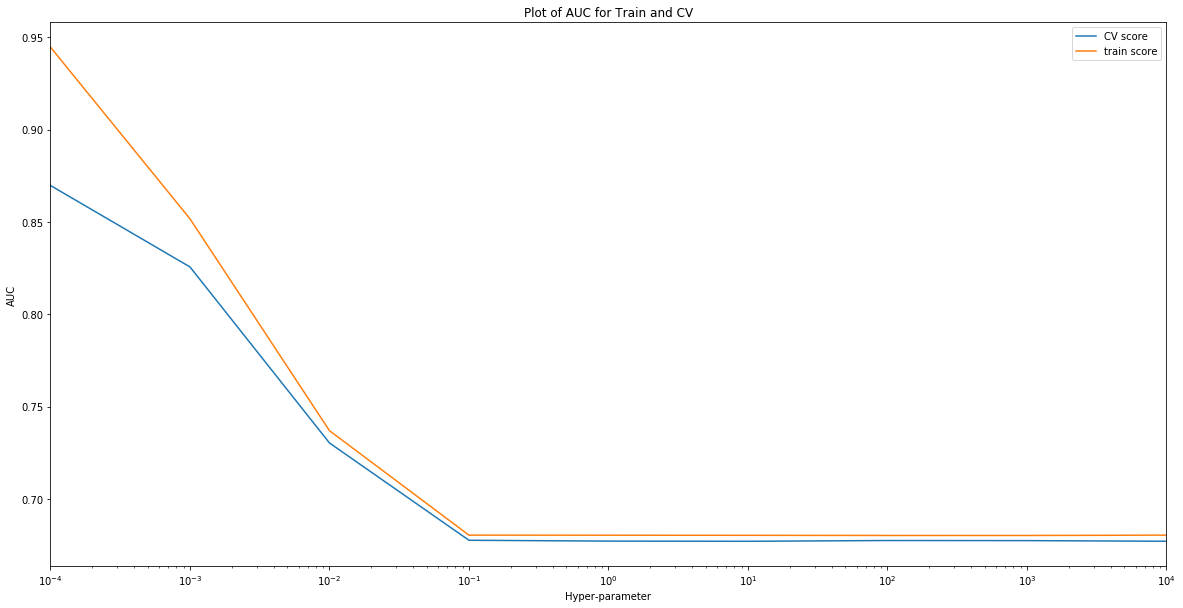

The optimal hyperparamter is  0.0001
*********************************************************************************************************************
AUC for Train data is   0.9345287476914741 

AUC for the Test data is   0.8804976917439234 



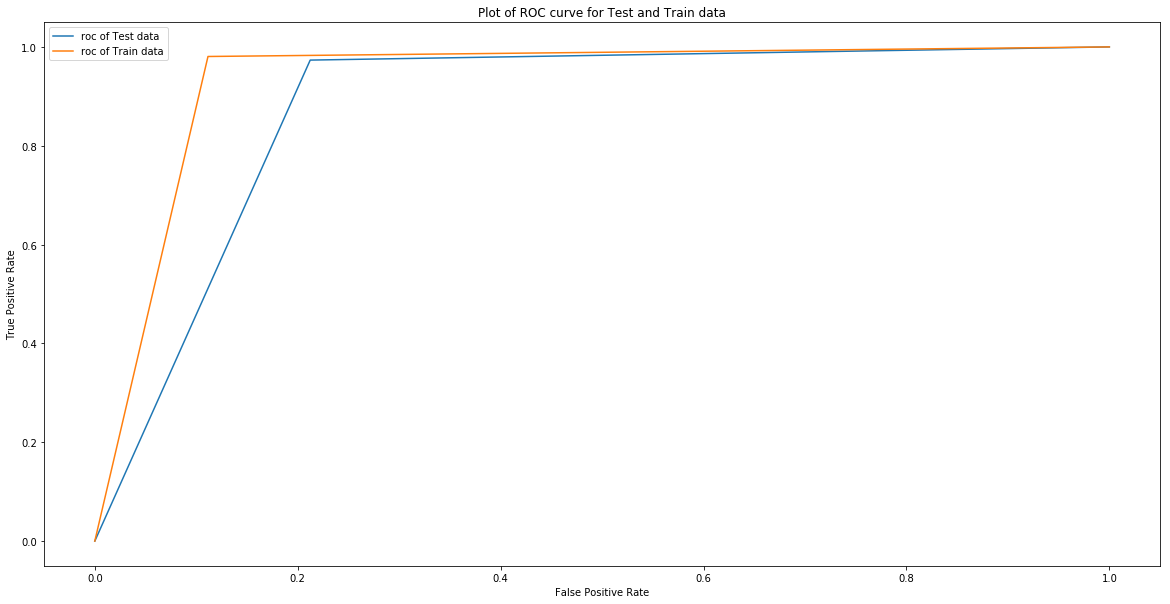

True positive rate = 97.33096085409252
True negative rate = 78.76857749469215
*********************************************************************************************************************
10 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-4.9529	count_vec__disappoint				4.8289	count_vec1__great
	-3.7190	count_vec__unfortun				4.3315	count_vec__delici
	-3.0011	count_vec__aw  				4.2759	count_vec1__delicious
	-2.8957	count_vec1__not worth				4.1964	count_vec1__excellent
	-2.8901	count_vec1__not good				3.6889	count_vec__great
	-2.8727	count_vec1__disappointed				3.5923	count_vec__excel
	-2.7213	count_vec1__worst				3.4658	count_vec1__best
	-2.6857	count_vec__terribl				3.2010	count_vec__not disappoint
	-2.5808	count_vec__veri disappoint				3.1684	count_vec1__good
	-2.4824	count_vec1__overpriced				3.1217	count_vec1__yummy


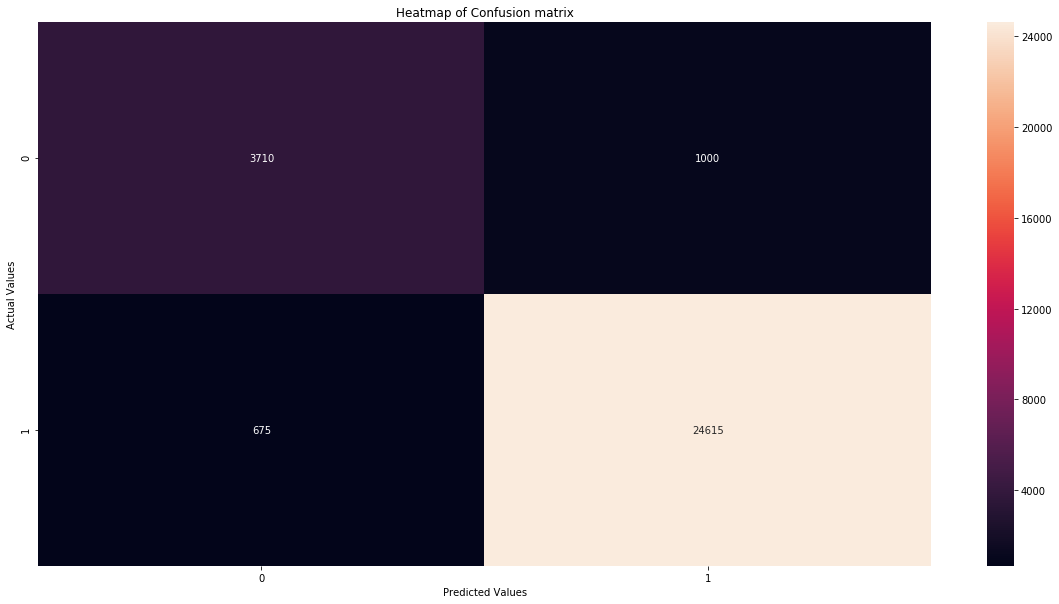

In [55]:

print('='*117)
optimal_alpha = clf(tfidfTrainFE, AmazonReviewDataSampledTrain['Score'],'linear','l2',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfTestFE,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l2','linear')
table1.add_row(['TFIDF','Linear','L2',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('*'*117)
TopFeatures(10,(combined_features),coef[0])
print('='*117)

<b>Linear SVM using L1 penalty

For alpha = 0.0001 , auc for train data = 0.8551900097484243 and auc for cv = 0.844395487773345 
For alpha = 0.001 , auc for train data = 0.7657323690970242 and auc for cv = 0.7609379502199147 
For alpha = 0.01 , auc for train data = 0.5587758416047999 and auc for cv = 0.5583268926915478 
For alpha = 0.1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 100 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1000 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10000 , auc for train data = 0.5 and auc for cv = 0.5 


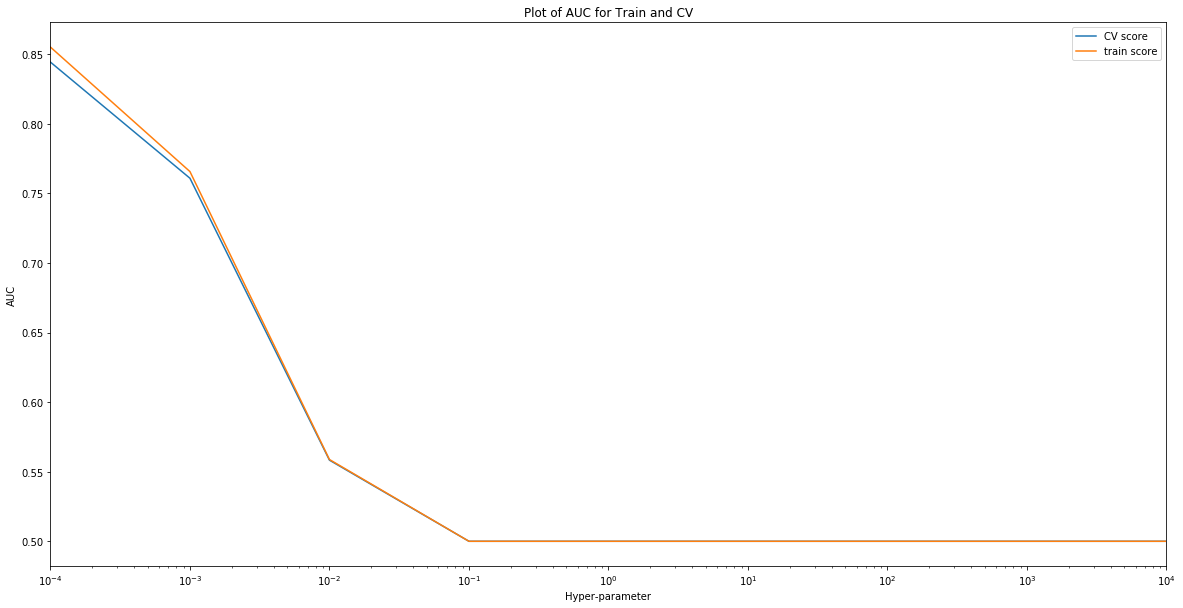

The optimal hyperparamter is  0.0001
*********************************************************************************************************************
AUC for Train data is   0.8549925144933872 

AUC for the Test data is   0.8546594535238369 



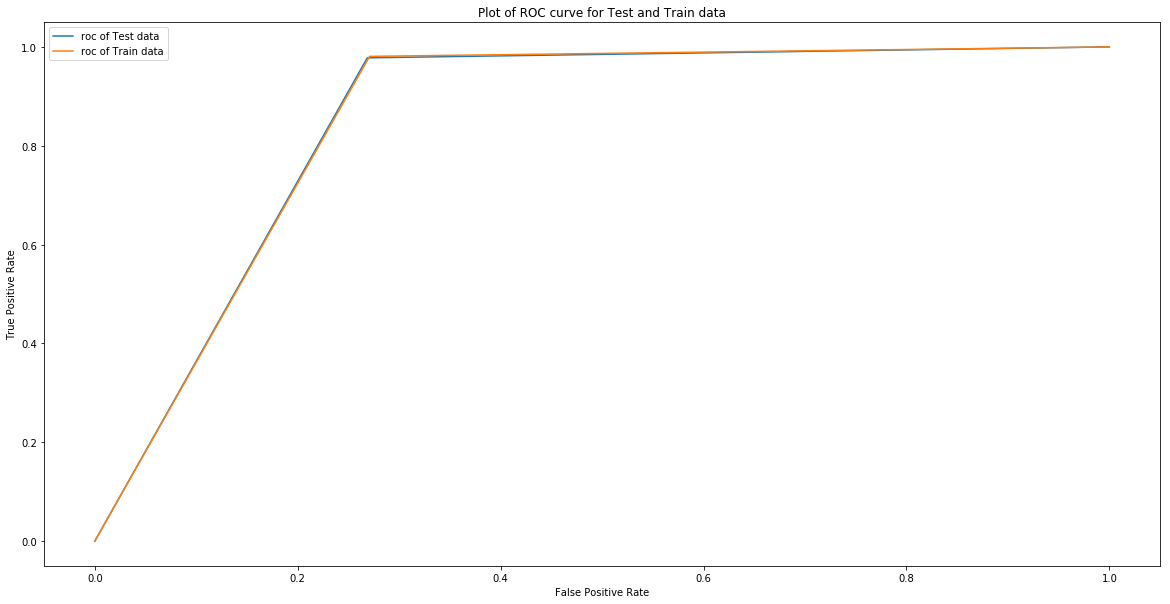

True positive rate = 97.78964017398181
True negative rate = 73.14225053078556
*********************************************************************************************************************
10 Most important features in Positive and Negative Class
			Negative						Positive
---------------------------------------------------------------------------------------------
	-27.4234	count_vec__aw  				17.2712	count_vec1__delicious
	-20.7682	count_vec1__yuck				15.7602	count_vec1__excellent
	-16.8940	count_vec__disappoint				15.2310	count_vec__delici
	-16.6925	count_vec__yuck				11.9528	count_vec__not disappoint
	-14.5626	count_vec__dal 				11.5167	count_vec__excel
	-14.2455	count_vec__old stale				10.7686	count_vec__happi
	-14.2035	count_vec__sodastream				10.6317	count_vec1__great
	-14.1228	count_vec__tast aw				9.1548	count_vec1__yummy
	-13.0779	count_vec__cancel				8.8451	count_vec1__tasty
	-12.8929	count_vec1__used				8.6443	count_vec__favorit


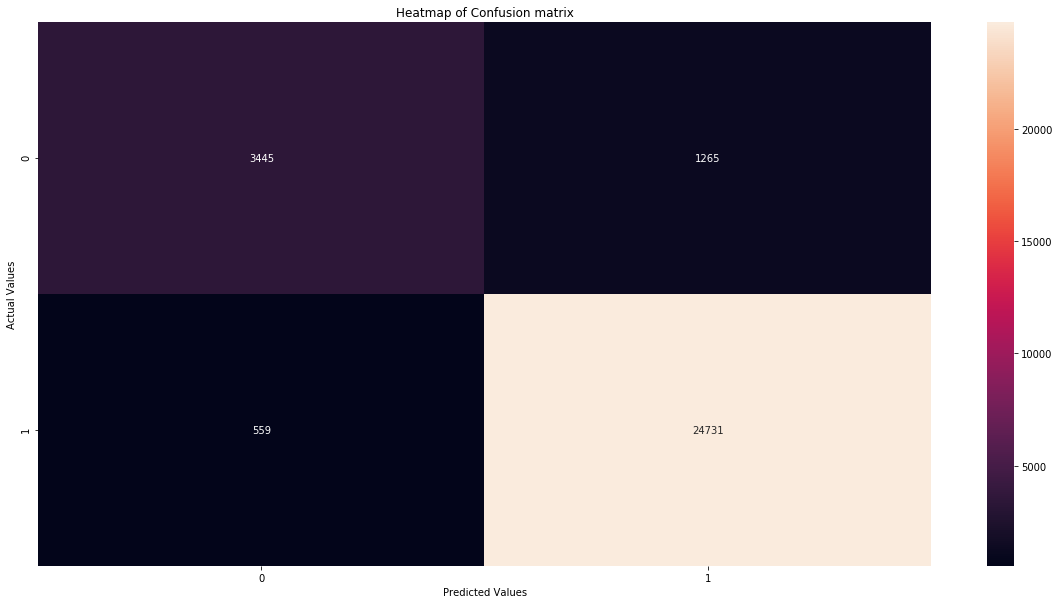

In [57]:

print('='*117)
optimal_alpha = clf(tfidfTrainFE, AmazonReviewDataSampledTrain['Score'],'linear','l1',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfTestFE,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l1','linear')
table1.add_row(['TFIDF','Linear','L1',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('*'*117)
TopFeatures(10,(combined_features),coef[0])
print('='*117)

### [6.3]  Applying Linear SVM on AVG W2V

In [58]:
#Combining the w2v of text and summary 
avgW2VTrainFE = np.concatenate((avgW2VTrain,avgW2VTrainSum),axis = 1)
avgW2VTestFE = np.concatenate((avgW2VTest,avgW2VTestSum),axis = 1)

<b> Linear SVM using penalty L2

For alpha = 0.0001 , auc for train data = 0.6524462298071996 and auc for cv = 0.6528434474737246 
For alpha = 0.001 , auc for train data = 0.7065050640462769 and auc for cv = 0.70515260441262 
For alpha = 0.01 , auc for train data = 0.7441726657954224 and auc for cv = 0.7436843678968877 
For alpha = 0.1 , auc for train data = 0.7447573395644952 and auc for cv = 0.743778120649546 
For alpha = 1 , auc for train data = 0.7342034778068685 and auc for cv = 0.732756403799667 
For alpha = 10 , auc for train data = 0.6969036060758856 and auc for cv = 0.6968819167538264 
For alpha = 100 , auc for train data = 0.6895252916275249 and auc for cv = 0.6890681213430284 
For alpha = 1000 , auc for train data = 0.6895073720529898 and auc for cv = 0.6890086891493228 
For alpha = 10000 , auc for train data = 0.6895889291344026 and auc for cv = 0.6895623014043946 


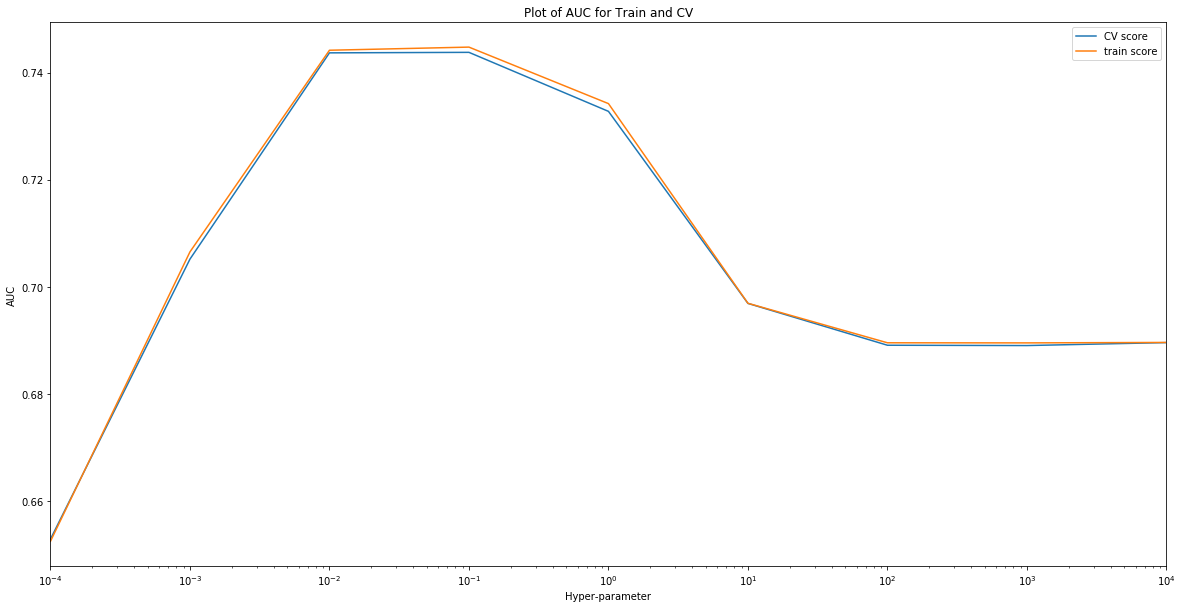

The optimal hyperparamter is  0.1
*********************************************************************************************************************
AUC for Train data is   0.7451296174566115 

AUC for the Test data is   0.7512536109788869 



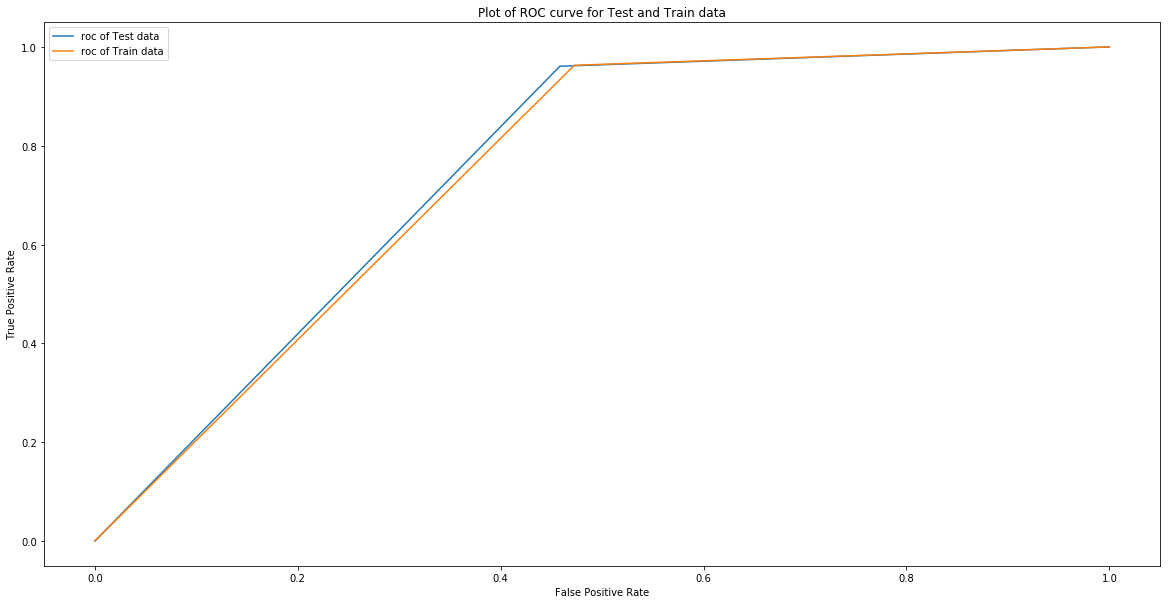

True positive rate = 96.08936338473704
True negative rate = 54.16135881104034


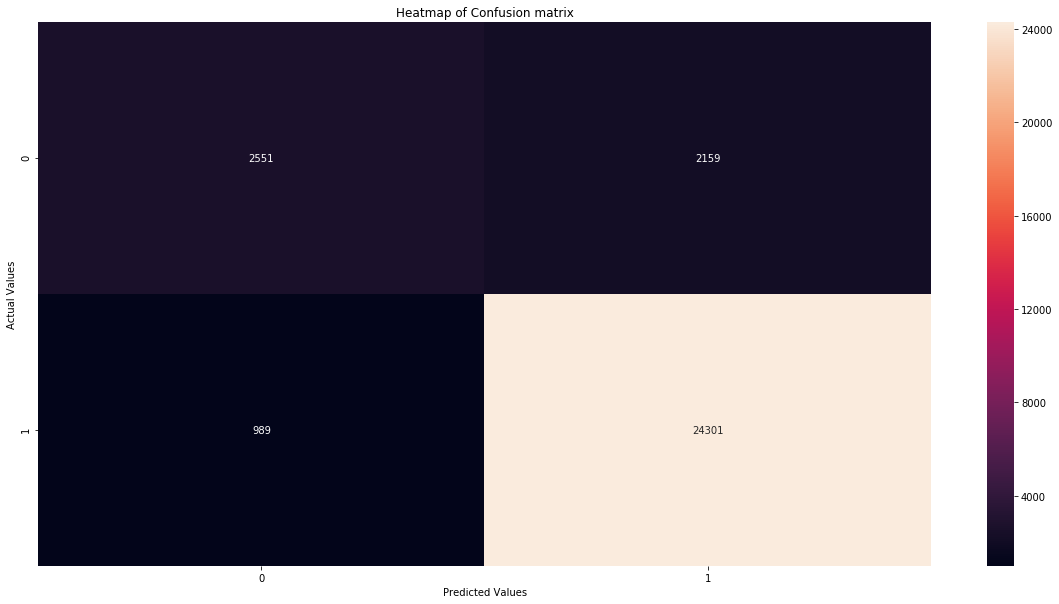

In [59]:

print('='*117)
optimal_alpha = clf(avgW2VTrainFE, AmazonReviewDataSampledTrain['Score'],'linear','l2',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrainFE,AmazonReviewDataSampledTrain['Score'],avgW2VTestFE,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l2','linear')
table1.add_row(['AVG W2V','Linear','L2',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

<b> Linear SVM using penalty L1

For alpha = 0.0001 , auc for train data = 0.6576048516334692 and auc for cv = 0.6576007332192267 
For alpha = 0.001 , auc for train data = 0.719178197044458 and auc for cv = 0.7173926159397693 
For alpha = 0.01 , auc for train data = 0.7294797860177211 and auc for cv = 0.7271594485629038 
For alpha = 0.1 , auc for train data = 0.6537485625699689 and auc for cv = 0.6535648944946534 
For alpha = 1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 100 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1000 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10000 , auc for train data = 0.5 and auc for cv = 0.5 


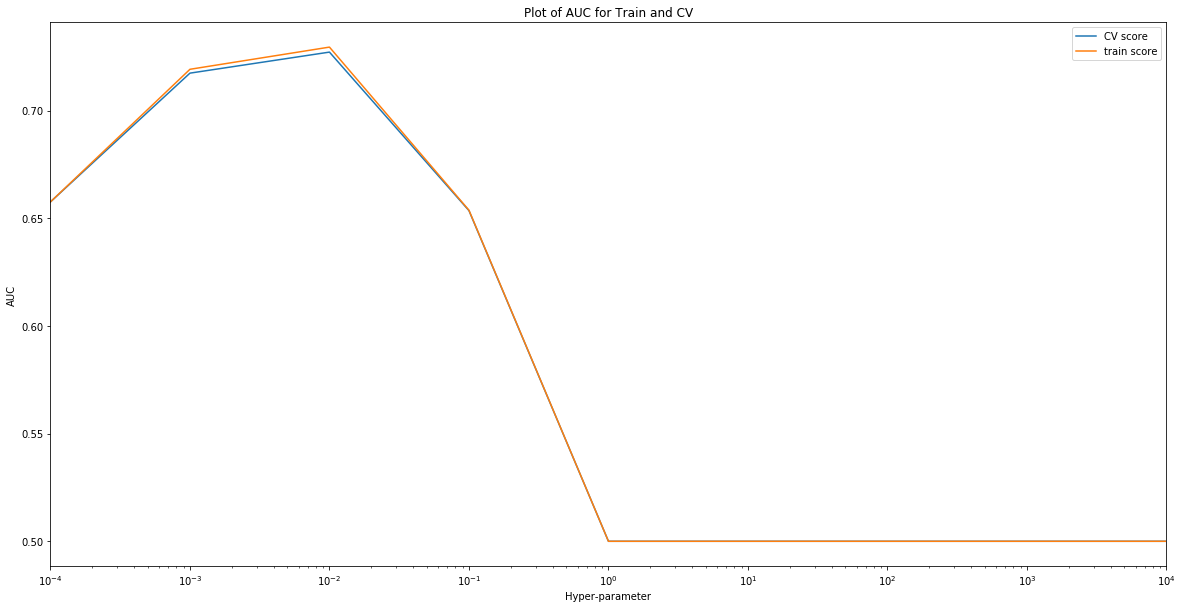

The optimal hyperparamter is  0.01
*********************************************************************************************************************
AUC for Train data is   0.7323628079878505 

AUC for the Test data is   0.7411403515399706 



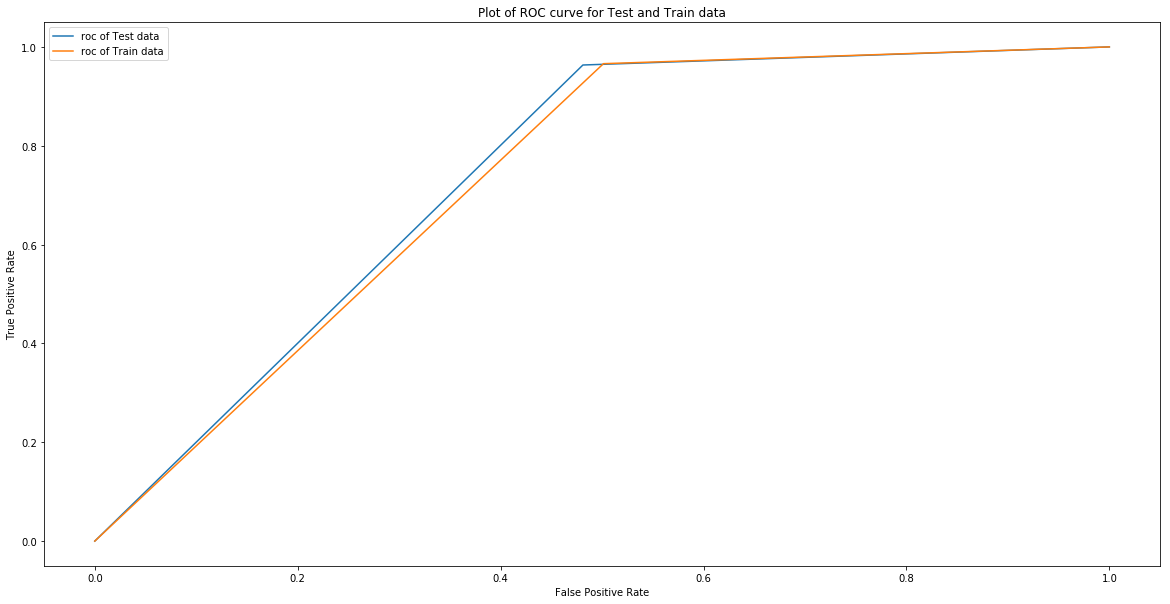

True positive rate = 96.33847370502174
True negative rate = 51.8895966029724


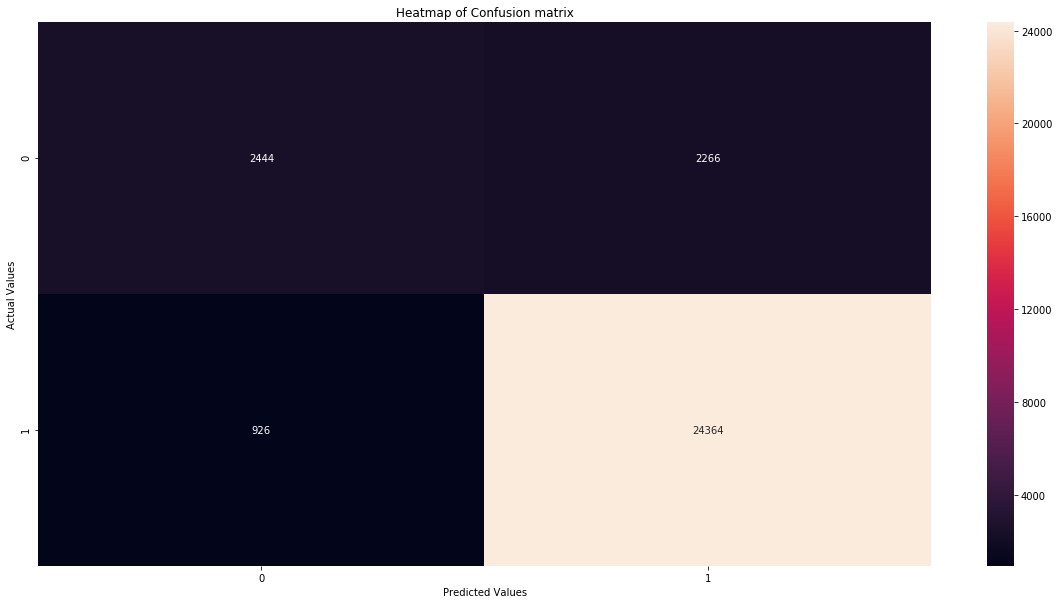

In [61]:

print('='*117)
optimal_alpha = clf(avgW2VTrainFE, AmazonReviewDataSampledTrain['Score'],'linear','l1',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(avgW2VTrainFE,AmazonReviewDataSampledTrain['Score'],avgW2VTestFE,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l1','linear')
table1.add_row(['AVG W2V','Linear','L1',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

### [6.4]  Applying Linear SVM on TFIDF W2V

In [62]:
#combining the TFIDFW2V of text and summary review
tfidfw2vTrainFE = np.concatenate((tfidfw2vTrain,tfidfw2vTrainSum),axis = 1)
tfidfw2vTestFE = np.concatenate((tfidfw2vTest,tfidfw2vTestSum),axis = 1)

<b> Linear SVM using L2 penalty

For alpha = 0.0001 , auc for train data = 0.5842745181613929 and auc for cv = 0.5843666855306306 
For alpha = 0.001 , auc for train data = 0.6515386338982075 and auc for cv = 0.6510369292649731 
For alpha = 0.01 , auc for train data = 0.692047955962594 and auc for cv = 0.6916927567805244 
For alpha = 0.1 , auc for train data = 0.6965660820956389 and auc for cv = 0.6962589609911926 
For alpha = 1 , auc for train data = 0.6846986471823302 and auc for cv = 0.6841681818139644 
For alpha = 10 , auc for train data = 0.6452682305183897 and auc for cv = 0.6442916966560872 
For alpha = 100 , auc for train data = 0.6366911153937588 and auc for cv = 0.636532794137741 
For alpha = 1000 , auc for train data = 0.6369556660978221 and auc for cv = 0.6366333741860357 
For alpha = 10000 , auc for train data = 0.6368703833229066 and auc for cv = 0.636710891712504 


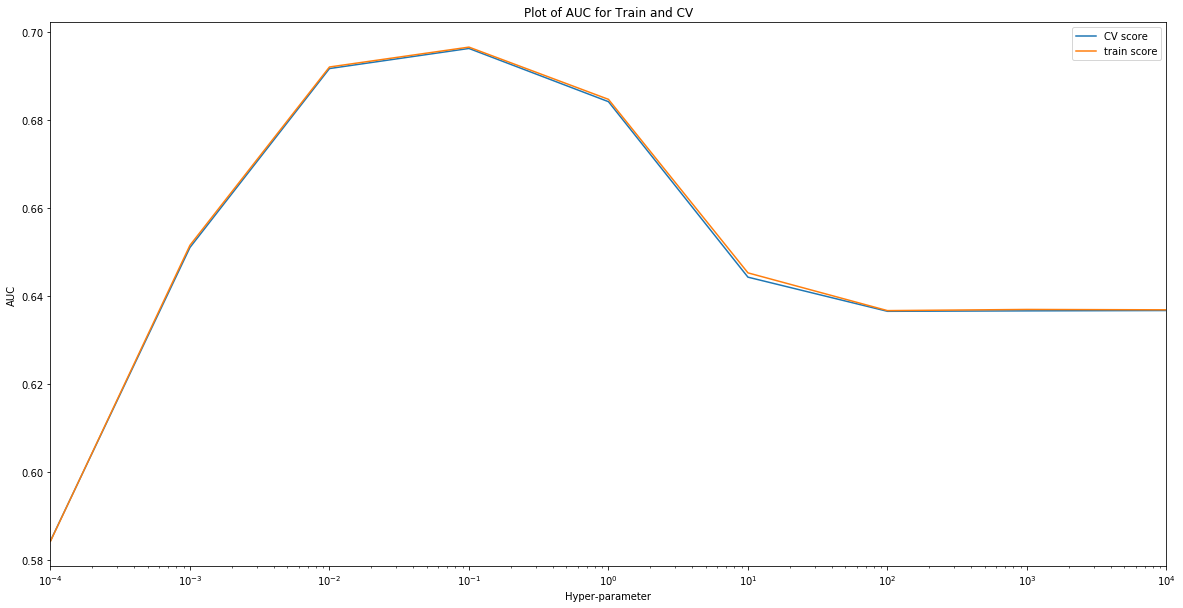

The optimal hyperparamter is  0.1
*********************************************************************************************************************
AUC for Train data is   0.6973716535144103 

AUC for the Test data is   0.7076084301088268 



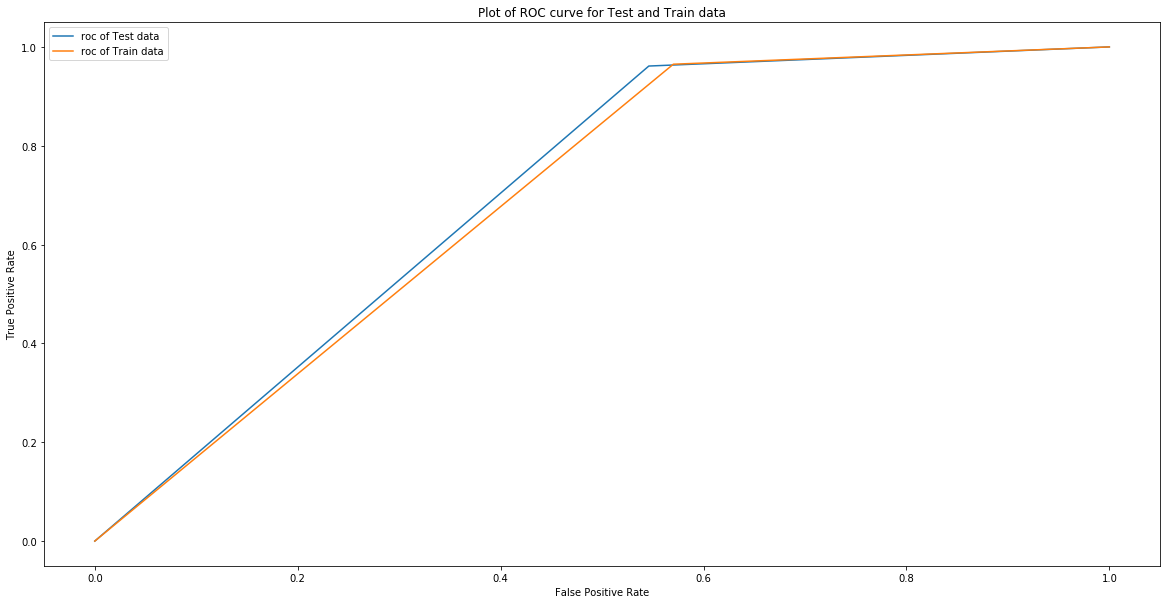

True positive rate = 96.12890470541716
True negative rate = 45.3927813163482


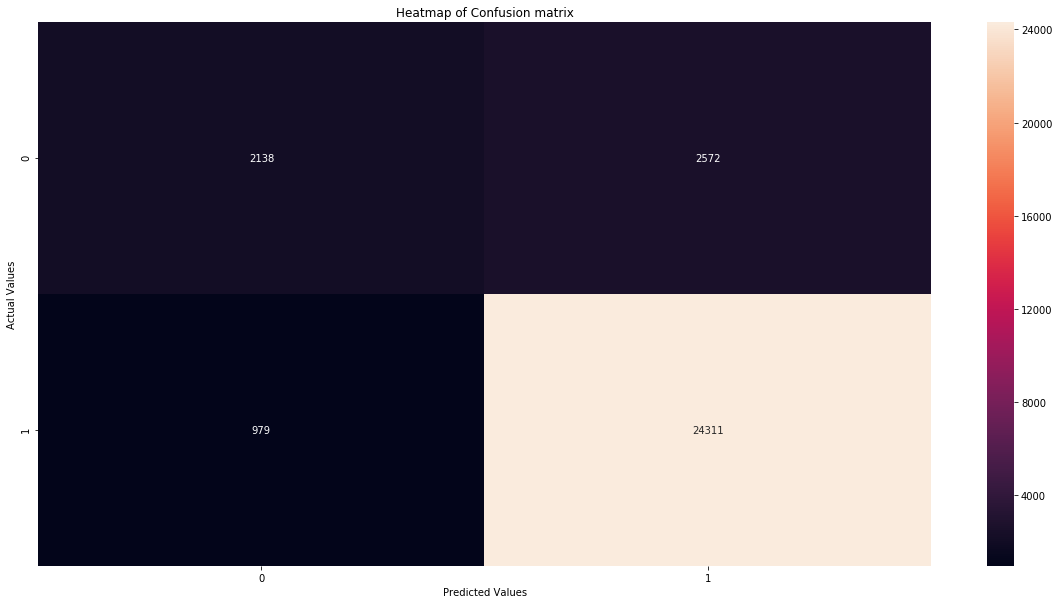

In [63]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(tfidfw2vTrainFE, AmazonReviewDataSampledTrain['Score'],'linear','l2',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfw2vTestFE,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l2','linear')
table1.add_row(['TFIDF W2V','Linear','L2',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

<b> Linear SVM using L1 penalty


For alpha = 0.0001 , auc for train data = 0.6082792650436105 and auc for cv = 0.6066339930838127 
For alpha = 0.001 , auc for train data = 0.6609890294239491 and auc for cv = 0.6611284287246854 
For alpha = 0.01 , auc for train data = 0.6817549935482702 and auc for cv = 0.6815278838349235 
For alpha = 0.1 , auc for train data = 0.6104752979647169 and auc for cv = 0.608237165476078 
For alpha = 1 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 100 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 1000 , auc for train data = 0.5 and auc for cv = 0.5 
For alpha = 10000 , auc for train data = 0.5 and auc for cv = 0.5 


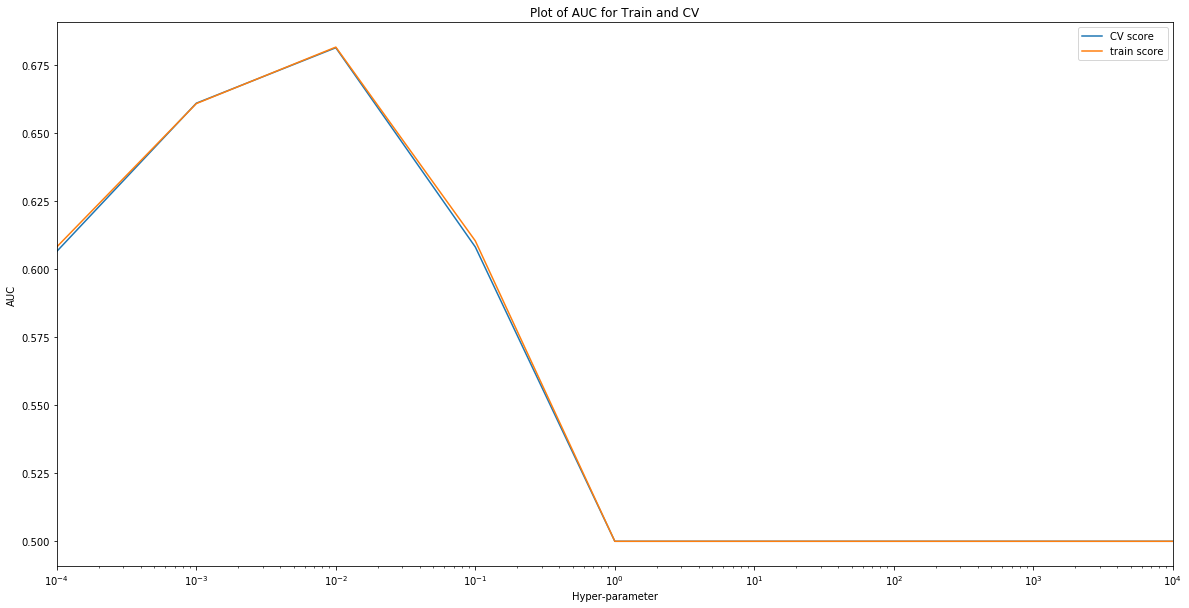

The optimal hyperparamter is  0.01
*********************************************************************************************************************
AUC for Train data is   0.6840080543403526 

AUC for the Test data is   0.6944643410325574 



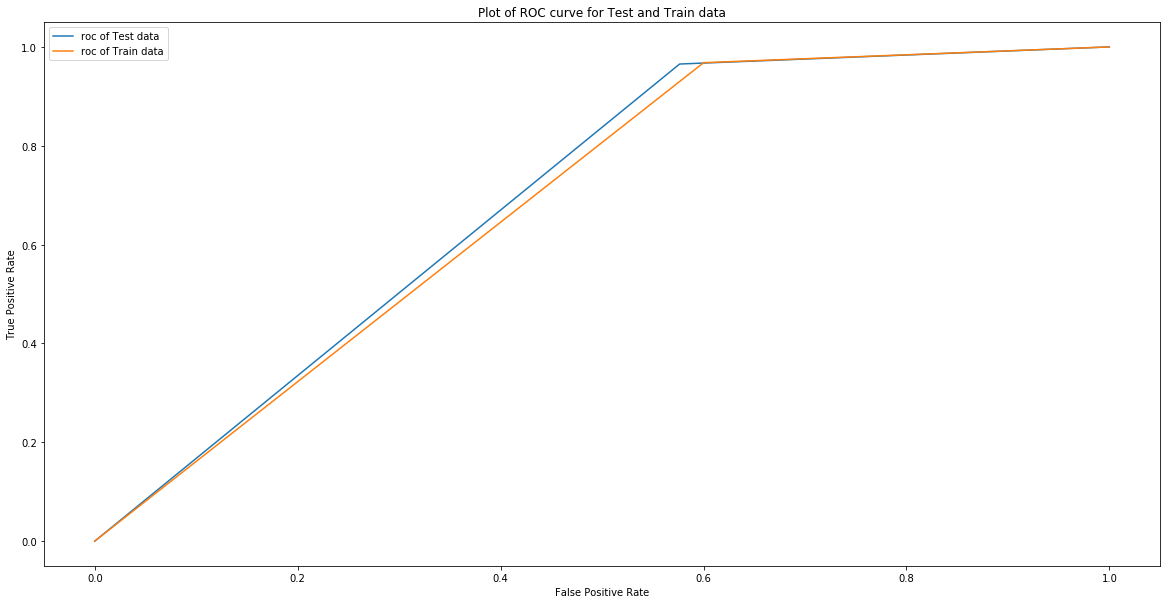

True positive rate = 96.5361803084223
True negative rate = 42.35668789808918


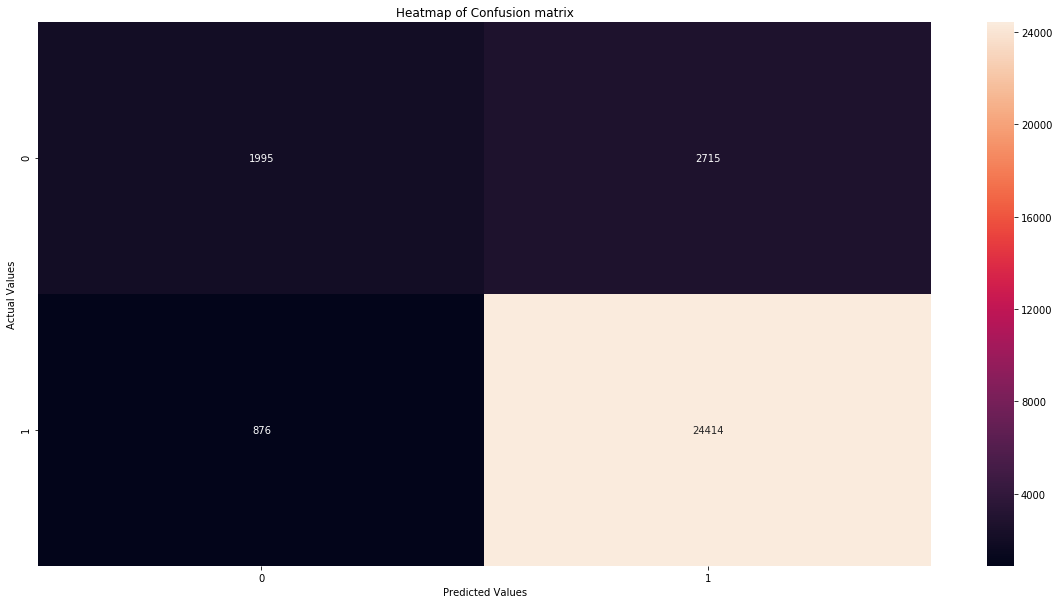

In [64]:
# Please write all the code with proper documentation
print('='*117)
optimal_alpha = clf(tfidfw2vTrainFE, AmazonReviewDataSampledTrain['Score'],'linear','l1',5)
print('The optimal hyperparamter is ',optimal_alpha)
print('*'*117)
auc_test,auc_train,TPR,TNR,coef = clfperformance(tfidfw2vTrainFE,AmazonReviewDataSampledTrain['Score'],tfidfw2vTestFE,AmazonReviewDataSampledTest['Score'],optimal_alpha,'l1','linear')
table1.add_row(['TFIDF W2V','Linear','L1',optimal_alpha,np.round(auc_test,4),np.round(TPR,3),np.round(TNR,3)])
print('='*117)

# [6] Conclusions

In [66]:
print(table2)

+--------------+-------------+---------+------------------------+--------+--------+--------+
|  Vectorizer  | Type of SVM | Penalty | optimal Hyperparameter |  AUC   |  TPR   |  TNR   |
+--------------+-------------+---------+------------------------+--------+--------+--------+
| Bag of Words |    Linear   |    L2   |         0.0001         | 0.7849 | 97.034 | 59.936 |
| Bag of Words |    Linear   |    L1   |         0.0001         | 0.7099 | 98.501 | 43.482 |
|    TFIDF     |    Linear   |    L2   |         0.001          | 0.8461 | 96.868 | 72.357 |
|    TFIDF     |    Linear   |    L1   |         0.0001         | 0.7912 | 98.58  | 59.66  |
|    AvgW2V    |    Linear   |    L2   |          0.1           | 0.6955 | 96.097 | 42.994 |
|    AvgW2V    |    Linear   |    L1   |          0.01          | 0.6891 | 96.267 | 41.55  |
|  TFIDF W2V   |    Linear   |    L2   |          0.1           | 0.6406 | 96.667 | 31.444 |
|  TFIDF W2V   |    Linear   |    L1   |          0.01          | 0.63

Table Showing the AUC for different vectorizer for Linear SVM

For Linear SVM from the above table, TFIDF vectorizer with L2 penalty performs well as compared to others. It has a better AUC score, thus providing with better True positive and True negative rate.

In [39]:
print(table4)

+--------------+-------------+------------------------+--------+--------+--------+
|  Vectorizer  | Type of SVM | optimal Hyperparameter |  AUC   |  TPR   |  TNR   |
+--------------+-------------+------------------------+--------+--------+--------+
| Bag of Words |     rbf     |          100           | 0.831  | 83.06  | 83.142 |
|    TFIDF     |     rbf     |         10000          | 0.8387 | 87.892 | 79.851 |
|    avgW2V    |     rbf     |          0.1           | 0.8232 | 81.214 | 83.418 |
|  TFIDF W2V   |     rbf     |           1            | 0.7986 | 81.222 | 78.493 |
+--------------+-------------+------------------------+--------+--------+--------+


Table showing the AUC for different vectorizer for RBF kernel SVM.

For RBF kernel SVM, TFIDF has a better AUC as compared to other vectorizers, but if we look at the TPR and TNR its the average w2v has better score. Hence with RBF kernel SVM, Average w2v performs better even though its auc is less than that of TFIDF. 

The performance of RBF kernel SVM can be improved further for bag of word and TFIDF vectorizer, if we could use  more number of features.

If we compare RBF kernel SVM with linear SVM, RBF performs far better.

In [67]:
print(table1)

+--------------+-------------+---------+------------------------+--------+--------+--------+
|  Vectorizer  | Type of SVM | Penalty | optimal Hyperparameter |  AUC   |  TPR   |  TNR   |
+--------------+-------------+---------+------------------------+--------+--------+--------+
| Bag of Words |    Linear   |    L2   |          0.01          | 0.8257 | 96.734 | 68.408 |
| Bag of Words |    Linear   |    L1   |         0.0001         | 0.7965 | 97.77  | 61.529 |
|    TFIDF     |    Linear   |    L2   |         0.0001         | 0.8805 | 97.331 | 78.769 |
|    TFIDF     |    Linear   |    L1   |         0.0001         | 0.8547 | 97.79  | 73.142 |
|   AVG W2V    |    Linear   |    L2   |          0.1           | 0.7513 | 96.089 | 54.161 |
|   AVG W2V    |    Linear   |    L1   |          0.01          | 0.7411 | 96.338 | 51.89  |
|  TFIDF W2V   |    Linear   |    L2   |          0.1           | 0.7076 | 96.129 | 45.393 |
|  TFIDF W2V   |    Linear   |    L1   |          0.01          | 0.69

Table showing the AUC for different vectorizer for Linear SVM using Feature Engineering.

By including the summary review alongwith Text review, the performance of the linear SVM is incresed. Again its the TFIDF which provides a better AUC,TPR and TNR as compared to others.
By including Feature engineering the performance of the RBF kernel SVM can also be increased. 

### RBF kernel SVM performs better as compared to linear SVM.

# END